In [2087]:

import importlib
import data_prep as dp
import macro_utils
import pandas as pd
importlib.reload(dp)
importlib.reload(macro_utils)
print(dir(dp))  # Check if functions appear now
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import numpy as np

Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [3]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

# OPTIONAL: concat recent news with existing df for trading.

In [2]:
df_live = dp.macro_analysis('./../clean_macro_4-10-25_to_17_news.csv', 'description', 'title')

Step 1: Loading data
Available columns in CSV: ['topic', 'title', 'description', 'source', 'published_at', 'url']
Columns after loading: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Data shape after loading: (2503, 7)
Step 2: Sorting by date
Min date: 2025-04-09 00:00:00, Max date: 2025-04-17 00:00:00
Columns after sorting: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Step 3: Calculating summary sentiment
Analyzing sentiment for 2503 entries in column 'description'...


Sentiment analysis for 'description':   5%|▍         | 119/2503 [00:03<01:16, 31.02it/s]


KeyboardInterrupt: 

In [3]:
df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv') #adjust for live/most recent df news under /data/live

In [449]:
df_live.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
3,2025-04-12,-0.089461,-0.957227,0.948515,90,43,-0.008691,-0.941981,0.939109,105,28,-0.049076,-0.949604,0.943812,195,71,30.889999
4,2025-04-13,-0.086733,-0.972444,0.952317,74,31,-0.158017,-0.968547,0.952738,71,34,-0.122375,-0.970495,0.952528,145,65,30.889999
5,2025-04-14,-0.063972,-0.972737,0.948741,239,123,-0.219557,-0.973235,0.940637,208,154,-0.141765,-0.972986,0.944689,447,277,30.889999
6,2025-04-15,-0.174286,-0.975042,0.950775,181,117,-0.138407,-0.974432,0.948124,195,103,-0.156347,-0.974737,0.949450,376,220,30.120001
7,2025-04-16,-0.254442,-0.974785,0.947952,205,169,-0.164961,-0.974998,0.955106,247,127,-0.209701,-0.974891,0.951529,452,296,32.639999


In [538]:
# Ensure 'date' columns are datetime
df['date'] = pd.to_datetime(df['date'])
df_live['date'] = pd.to_datetime(df_live['date'])

# Remove overlap: drop April 10 from df_live if it exists in df
df_live_trimmed = df_live[df_live['date'] > df['date'].max()]

# Merge the two
df = pd.concat([df, df_live_trimmed], ignore_index=True)


KeyError: 'date'

In [452]:
df = df.drop(columns=['Unnamed: 0'])

In [453]:
df.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
1957,2025-04-12,-0.089461,-0.957227,0.948515,90,43,-0.008691,-0.941981,0.939109,105,28,-0.049076,-0.949604,0.943812,195,71,30.889999
1958,2025-04-13,-0.086733,-0.972444,0.952317,74,31,-0.158017,-0.968547,0.952738,71,34,-0.122375,-0.970495,0.952528,145,65,30.889999
1959,2025-04-14,-0.063972,-0.972737,0.948741,239,123,-0.219557,-0.973235,0.940637,208,154,-0.141765,-0.972986,0.944689,447,277,30.889999
1960,2025-04-15,-0.174286,-0.975042,0.950775,181,117,-0.138407,-0.974432,0.948124,195,103,-0.156347,-0.974737,0.949450,376,220,30.120001
1961,2025-04-16,-0.254442,-0.974785,0.947952,205,169,-0.164961,-0.974998,0.955106,247,127,-0.209701,-0.974891,0.951529,452,296,32.639999


In [1651]:
df = pd.read_csv('./../data/live/7y_up_to_4_17_2025_news.csv')
df = macro_utils.calculate_stats(df)
df['vix_target'] = np.log(df['vix_target'])

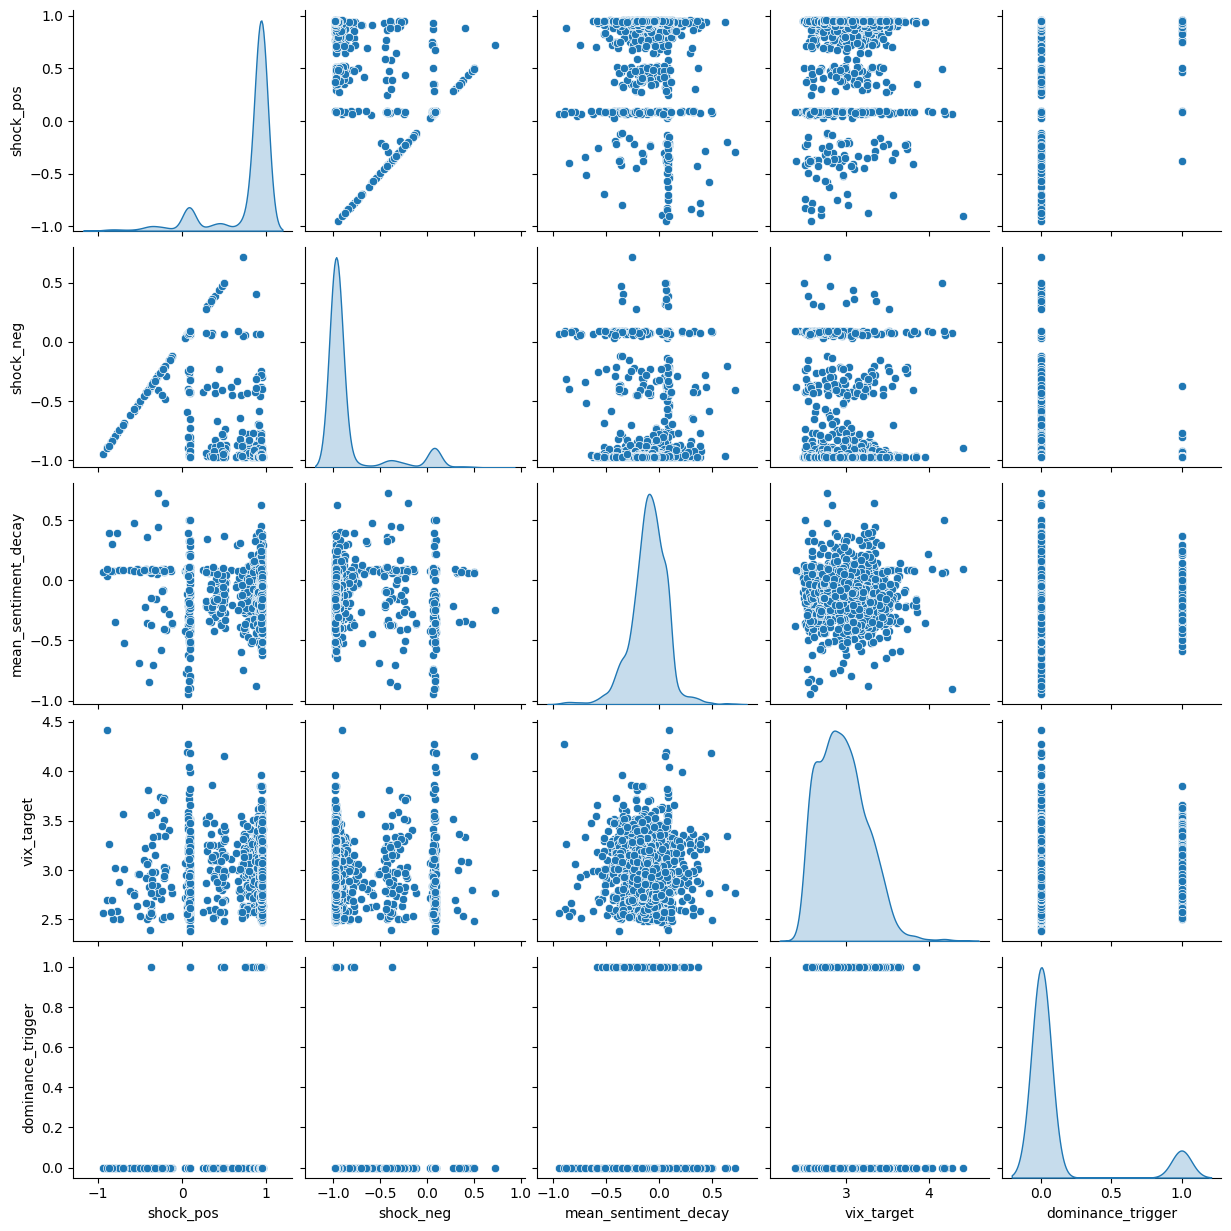

In [1652]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target', 'dominance_trigger'], diag_kind='kde')


In [1653]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]
selected_features = feature_sets[0]

In [1654]:
df.index = pd.to_datetime(df['date'])
df.tail()

,date,date.1,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore
date,,,,,,,,,,,,,,,,,,,,,
2025-04-12,2025-04-12,2025-04-12,-0.089461,-0.957227,0.948515,90,43,-0.008691,-0.941981,0.939109,...,-0.304711,0.943812,-0.949604,47,0,0.426790,0.340215,30.907810,11.605613,-0.001535
2025-04-13,2025-04-13,2025-04-13,-0.086733,-0.972444,0.952317,74,31,-0.158017,-0.968547,0.952738,...,-0.049076,0.952528,-0.970495,43,0,0.386445,0.313508,30.906581,11.198272,-0.001481
2025-04-14,2025-04-14,2025-04-14,-0.063972,-0.972737,0.948741,239,123,-0.219557,-0.973235,0.940637,...,-0.122375,0.944689,-0.972986,116,0,0.386445,0.283756,30.905438,10.805228,-0.001429
2025-04-15,2025-04-15,2025-04-15,-0.174286,-0.975042,0.950775,181,117,-0.138407,-0.974432,0.948124,...,-0.141765,0.949450,-0.974737,64,0,0.351885,0.185777,30.851270,10.427948,-0.070126
2025-04-16,2025-04-16,2025-04-16,-0.254442,-0.974785,0.947952,205,169,-0.164961,-0.974998,0.955106,...,-0.156347,0.951529,-0.974891,36,0,0.499311,0.382230,30.974630,10.072522,0.165338


In [1655]:
df = df.drop(columns=['date', 'date.1'])

In [1656]:
df = df.drop(columns=['summary_max', 'summary_pos_count', 'headline_max', 'overall_max', 'shock_pos'])

In [1657]:
#df['vix_target_log'] = np.log(df['vix_target'])
#df['vix_target_log_ret'] = df['vix_target_log'].diff().dropna()

# Train: Post-COVID to end of 2023
#train_df = df[(df.index >= "2018-05-01") & (df.index <= "2024-10-15")]
train_df = df[(df.index <= "2024-10-15")]
# Test: Recent years
test_df = df[df.index >= "2024-10-16"]
print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[0] + ['vix_zscore']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_ewm_zscore']


Train set: 1692 rows
Test set: 183 rows


In [1658]:
train_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_target,mean_sentiment_decay,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore
date,,,,,,,,,,,,,,,,,,,,,
2018-03-18,-0.806745,-0.806745,1,0.048595,0.048595,1,0,-0.379075,-0.379075,1,...,2.945491,0.071321,-0.379075,-1,0,0.374277,0.653030,16.812508,5.459736,0.404322
2018-03-30,0.084789,0.084789,0,0.084558,0.084558,1,0,0.084673,0.084673,2,...,3.162094,-0.379075,0.084673,1,0,0.753526,1.318488,17.339500,5.562713,1.129036
2018-04-06,0.091514,0.091514,0,0.065591,0.065591,1,0,0.078553,0.078553,2,...,3.067588,0.084673,0.078553,1,0,0.241479,0.908250,17.658113,5.461237,0.701652
2018-04-08,-0.896965,-0.896965,1,0.072943,0.072943,1,0,-0.412011,-0.412011,1,...,3.080533,0.078553,-0.412011,-1,0,-0.416667,0.892227,17.971320,5.364610,0.708100
2018-04-10,-0.525443,-0.638223,3,0.080863,0.068002,3,0,-0.222290,-0.285111,3,...,3.018960,-0.412011,-0.285111,-3,0,-0.200703,0.631611,18.160285,5.200269,0.444153


In [1659]:
test_df_trade = test_df.copy()

In [1660]:
test_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_target,mean_sentiment_decay,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore
date,,,,,,,,,,,,,,,,,,,,,
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,3.430432,-0.304711,-0.949604,47,0,0.426790,0.340215,30.907810,11.605613,-0.001535
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,3.430432,-0.049076,-0.970495,43,0,0.386445,0.313508,30.906581,11.198272,-0.001481
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,3.430432,-0.122375,-0.972986,116,0,0.386445,0.283756,30.905438,10.805228,-0.001429
2025-04-15,-0.174286,-0.975042,117,-0.138407,-0.974432,195,103,-0.156347,-0.974737,376,...,3.405189,-0.141765,-0.974737,64,0,0.351885,0.185777,30.851270,10.427948,-0.070126
2025-04-16,-0.254442,-0.974785,169,-0.164961,-0.974998,247,127,-0.209701,-0.974891,452,...,3.485539,-0.156347,-0.974891,36,0,0.499311,0.382230,30.974630,10.072522,0.165338


In [2078]:
transition_matrix, results, df_model = macro_utils.regime_t_markov_model(X, y, df_model)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 48 and the array at index 1 has size 1692

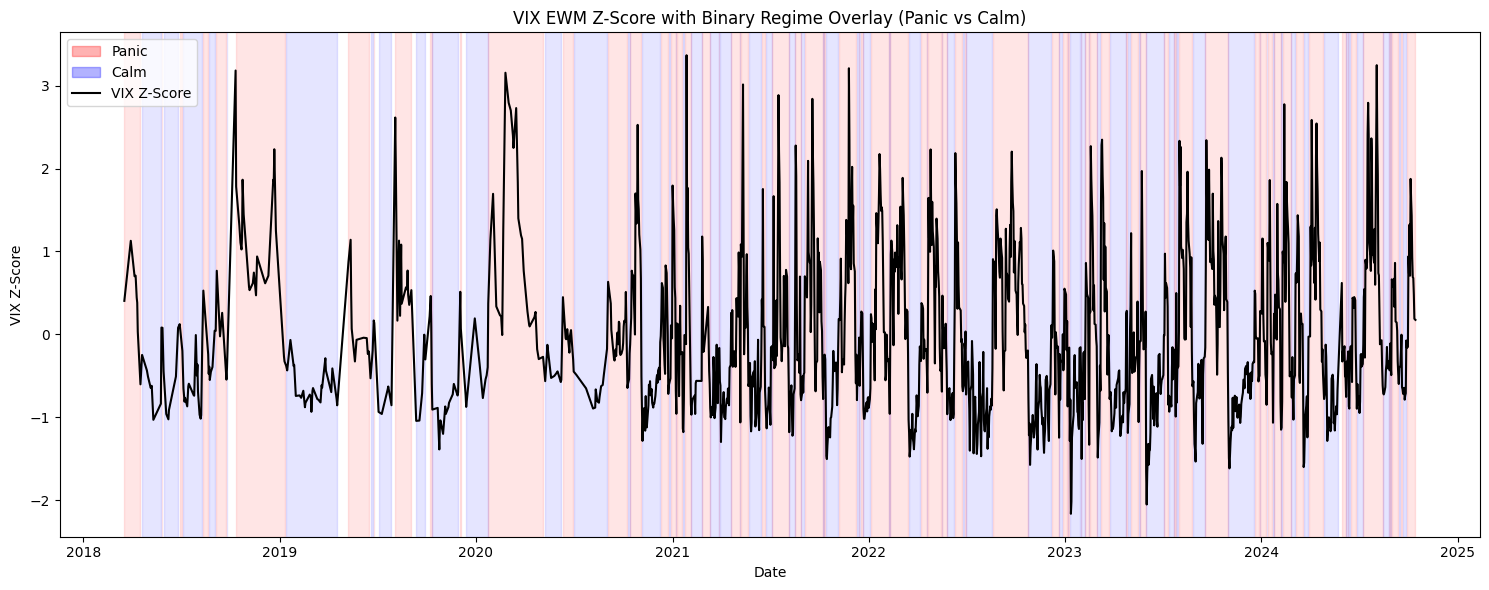

In [1662]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_ewm_zscore'], label='VIX_t (EWM Z-Score)', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.1)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.1)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX EWM Z-Score with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


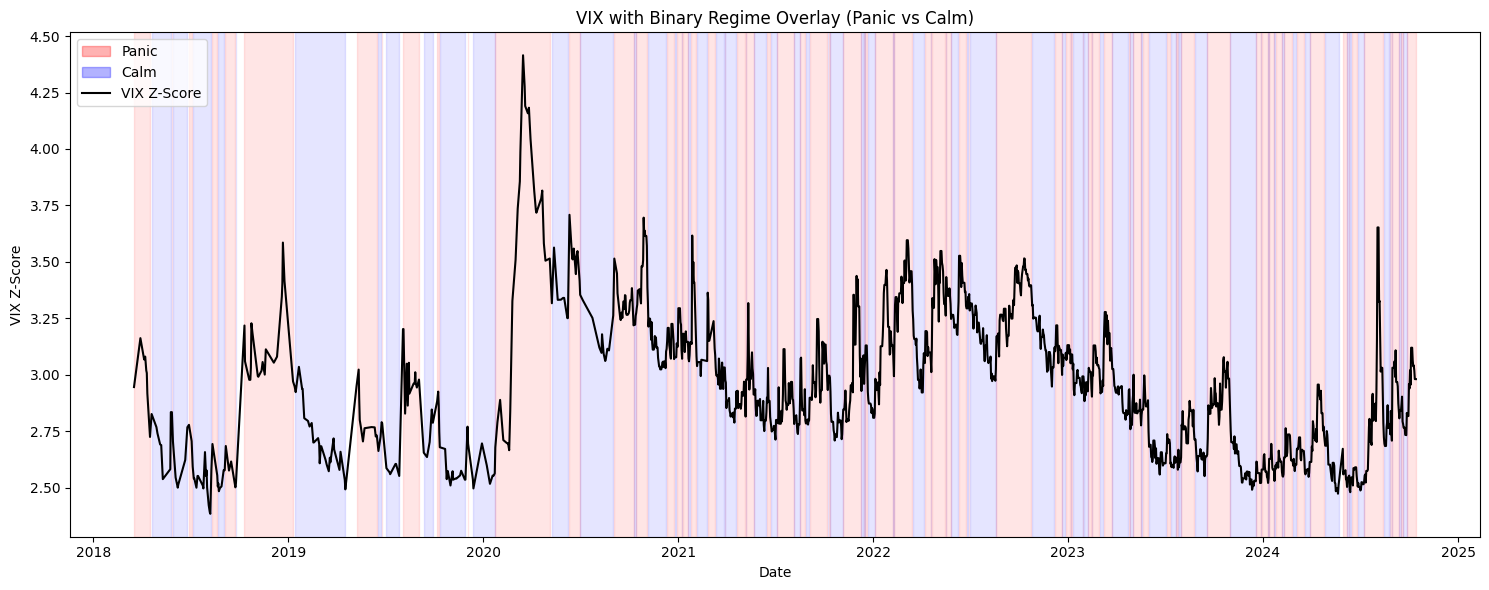

In [1663]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_target'], label='VIX_t', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.1)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.1)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


In [1664]:
df_model.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_mean,ewm_std,vix_ewm_zscore,regime_t_raw,regime_t,regime_0_prob,regime_1_prob,regime_2_prob,regime_t+1,regime_t+1_raw
date,,,,,,,,,,,,,,,,,,,,,
2024-10-10,-0.008239,-0.976220,42,-0.162519,-0.972208,66,47,-0.085379,-0.974214,137,...,19.091777,2.705365,0.679473,2,1,0.000060,0.173607,0.826332,1.0,1.0
2024-10-11,-0.313376,-0.972448,58,-0.157393,-0.971905,57,48,-0.235385,-0.972176,104,...,19.186137,2.634178,0.483590,1,1,0.000825,0.792760,0.206415,1.0,1.0
2024-10-12,0.181630,-0.959148,9,0.054226,-0.946041,31,6,0.117928,-0.952595,59,...,19.221576,2.545179,0.187973,1,1,0.006900,0.978617,0.014484,1.0,1.0
2024-10-13,-0.280690,-0.969393,10,-0.232838,-0.916358,12,8,-0.256764,-0.942875,22,...,19.254571,2.458947,0.181147,1,1,0.008042,0.987826,0.004132,1.0,1.0
2024-10-14,0.009047,-0.974299,24,-0.044218,-0.972195,43,20,-0.017585,-0.973247,82,...,19.285290,2.375424,0.174584,1,1,0.008164,0.987879,0.003957,1.0,1.0


In [1665]:
clf, y_pred, classification_df = macro_utils.clf_panic_tomorrow(df_model, selected_features, 'regime_t+1')

              precision    recall  f1-score   support

         0.0       0.79      0.39      0.52       755
         1.0       0.65      0.91      0.76       936

    accuracy                           0.68      1691
   macro avg       0.72      0.65      0.64      1691
weighted avg       0.71      0.68      0.65      1691



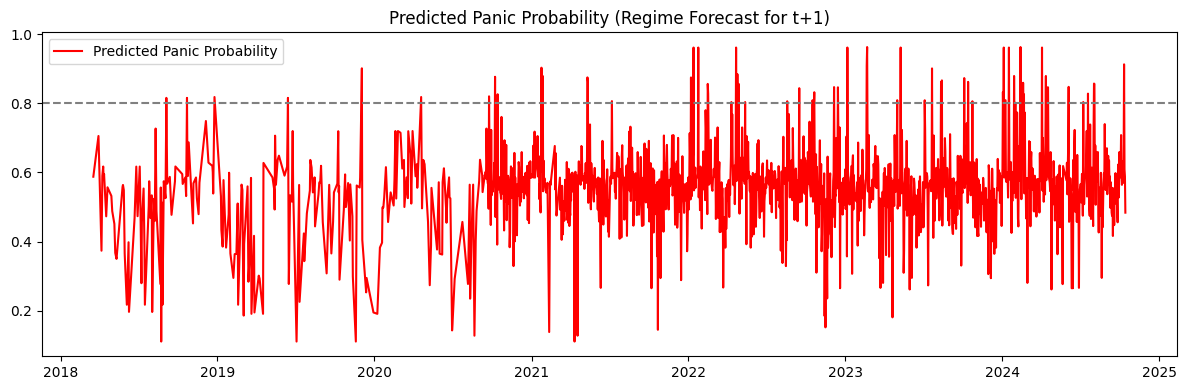

In [1666]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.8, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


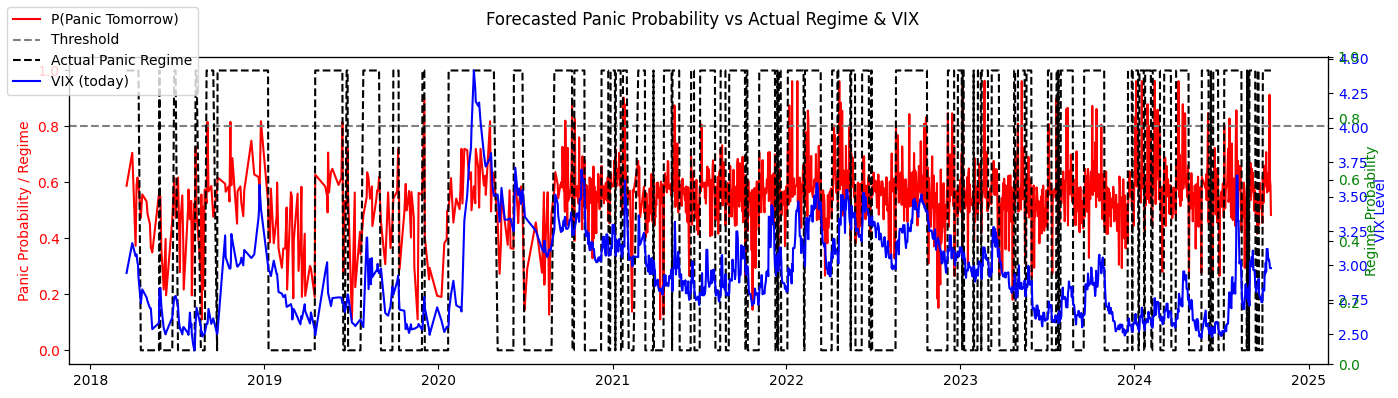

In [1667]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.8, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
#ax3.plot(classification_df.index, classification_df['regime_t_raw'], label='Regime Probability', color='green')
ax3.set_ylabel("Regime Probability", color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


for each regime=1, we now get the set of days aferwards to see how vix behaves as soon as the model changes regime

In [1668]:

# Train dataset (classification_df)
classification_df = macro_utils.identify_sustained_regimes_and_transitions(classification_df)

# Now you can apply it to the test data (test_df) in the same way:




In [1669]:
classification_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,regime_0_prob,regime_1_prob,regime_2_prob,regime_t+1,regime_t+1_raw,panic_prob,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-10-10,-0.008239,-0.976220,42,-0.162519,-0.972208,66,47,-0.085379,-0.974214,137,...,0.000060,0.173607,0.826332,1.0,1.0,0.636550,139,True,1.0,False
2024-10-11,-0.313376,-0.972448,58,-0.157393,-0.971905,57,48,-0.235385,-0.972176,104,...,0.000825,0.792760,0.206415,1.0,1.0,0.913149,139,True,1.0,False
2024-10-12,0.181630,-0.959148,9,0.054226,-0.946041,31,6,0.117928,-0.952595,59,...,0.006900,0.978617,0.014484,1.0,1.0,0.609169,139,True,1.0,False
2024-10-13,-0.280690,-0.969393,10,-0.232838,-0.916358,12,8,-0.256764,-0.942875,22,...,0.008042,0.987826,0.004132,1.0,1.0,0.588405,139,True,1.0,False
2024-10-14,0.009047,-0.974299,24,-0.044218,-0.972195,43,20,-0.017585,-0.973247,82,...,0.008164,0.987879,0.003957,1.0,1.0,0.483686,139,True,1.0,False


In [1670]:

# Usage Example:
result = macro_utils.transform_vix_data(classification_df, window=60)
vix_windows_df_train = result["vix_windows_df_train"]
regime_windows_df_train = result["regime_windows_df_train"]
vix_windows_past_df_train = result["vix_windows_past_df_train"]


In [1671]:

regime_windows_df_train = regime_windows_df_train.replace(2, 1)


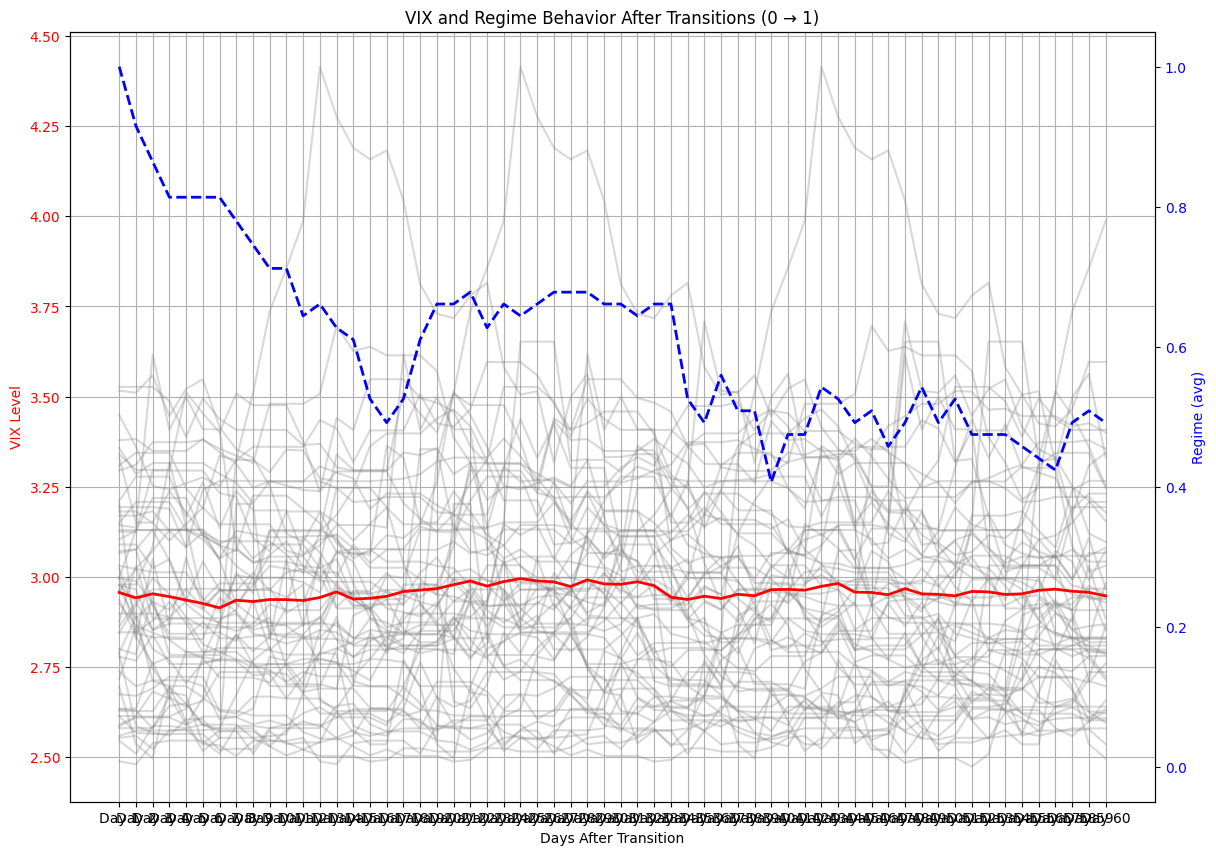

In [1672]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_train.T, color="gray", alpha=0.3, label="Individual VIX transitions")
ax1.plot(vix_windows_df_train.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_train.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#plt.tight_layout()
plt.show()



since some spikes happen quite some time after the regime switches, we will build a classifier for 0 (immediate) or 1 (delayed), then feed this into a model for vix level forecasting

In [1673]:
vix_windows_past_df_train.tail()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-03-30,2.588516,2.663750,2.630449,2.628285,2.615204,2.615204,2.615204,2.569554,2.551786,2.548664,...,2.568022,2.558777,2.569554,2.579459,2.579459,2.579459,2.583243,2.547881,2.565718,2.613739
2024-05-30,2.579459,2.579459,2.583243,2.547881,2.565718,2.613739,2.613739,2.613739,2.613739,2.681706,...,2.610070,2.596746,2.521721,2.519308,2.484073,2.497329,2.497329,2.497329,2.473171,2.508786
2024-06-11,2.774462,2.720637,2.720637,2.720637,2.706716,2.760010,2.702032,2.851284,2.956472,2.956472,...,2.573375,2.573375,2.573375,2.577182,2.536075,2.532108,2.503074,2.544747,2.544747,2.544747
2024-06-16,2.760010,2.702032,2.851284,2.956472,2.956472,2.956472,2.912351,2.901971,2.890372,2.929058,...,2.532108,2.503074,2.544747,2.544747,2.544747,2.553344,2.488234,2.479894,2.538447,2.545531
2024-07-09,2.601949,2.601949,2.601949,2.601949,2.582487,2.564949,2.540814,2.529721,2.610070,2.610070,...,2.503074,2.503074,2.503074,2.487404,2.492379,2.524127,2.524127,2.515274,2.515274,2.515274


In [1674]:
vix_windows_df_train.iloc[-1].max()

np.float64(3.6524747643078785)

In [1675]:
df_delayed_spike_prob, clf_delayed_spike_prob, vix_pct_change_lookback_df_train = macro_utils.clf_delayed_spike_prob(vix_windows_df_train, df_model, "vix_target")

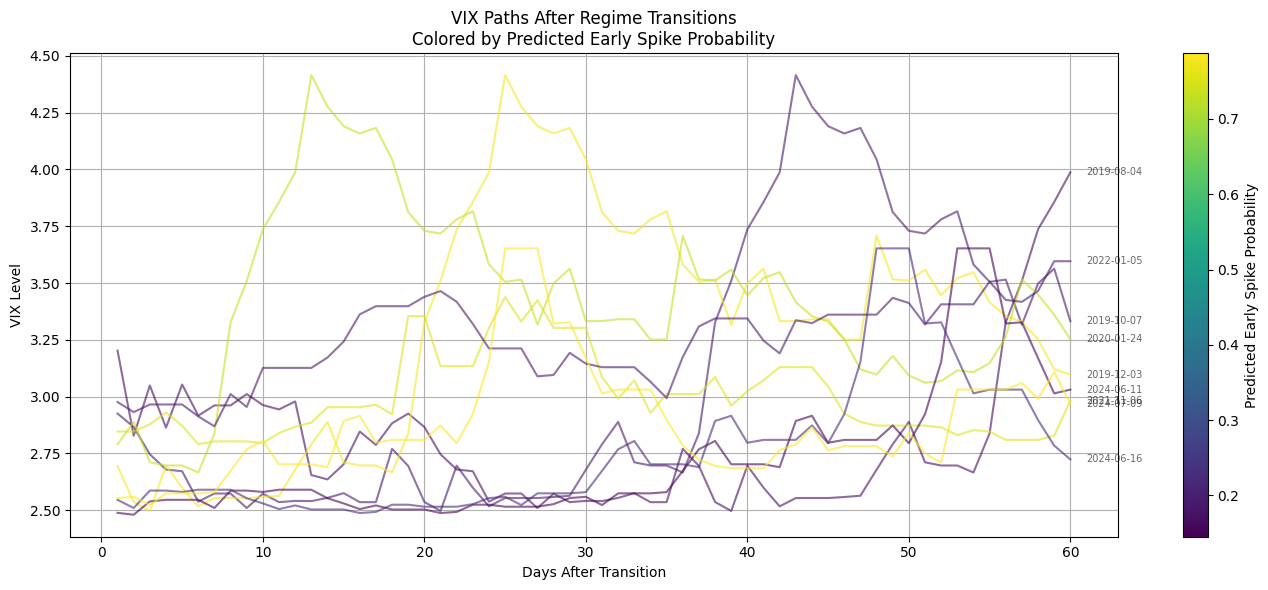

In [1676]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [1677]:
vix_windows_df_train

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2019-05-09,3.022861,2.893700,2.799717,2.770086,2.704711,2.763170,2.768204,2.766948,2.726545,2.731115,...,2.540026,2.554122,2.574900,2.535283,2.535283,2.770086,2.694627,2.536075,2.496506,NaN
2019-06-25,2.785628,2.586259,2.567254,2.559550,2.604909,2.604909,2.551786,3.202340,3.202340,2.827905,...,2.553344,2.553344,2.558002,2.563410,2.678278,2.789937,2.888704,2.710713,2.696652,NaN
2019-08-04,3.202340,2.827905,3.048799,2.863343,3.053057,2.916148,2.961141,2.961141,3.011113,2.962692,...,2.696652,2.696652,2.665838,2.837908,3.326833,3.509154,3.736240,3.856510,3.987131,0.1650
2019-10-07,2.925310,2.866193,2.745988,2.678965,2.671386,2.537657,2.573375,2.573375,2.509599,2.572612,...,3.780319,3.815732,3.581573,3.505257,3.514824,3.316728,3.497719,3.563316,3.331847,0.1850
2019-12-03,2.694627,2.536075,2.496506,2.695978,2.598979,2.516890,2.553344,2.553344,2.553344,2.558002,...,3.445852,3.521644,3.547604,3.415429,3.354106,3.330059,3.251924,3.120160,3.096934,0.7775
2020-01-24,2.789937,2.888704,2.710713,2.696652,2.696652,2.665838,2.837908,3.326833,3.509154,3.736240,...,3.068518,3.115292,3.107721,3.147165,3.262701,3.514526,3.448717,3.360723,3.252311,0.7300
2020-06-11,3.516607,3.510650,3.558771,3.445852,3.521644,3.547604,3.415429,3.354106,3.330059,3.251924,...,3.260785,3.273364,3.294725,3.310908,3.373484,3.373484,3.373484,3.379293,3.355153,NaN
2020-09-03,3.448717,3.360723,3.252311,3.242202,3.259634,3.275634,3.251537,3.324316,3.324316,3.290638,...,3.570940,3.386760,3.317091,3.213260,3.248435,3.248435,3.248435,3.210844,3.154871,NaN
2020-10-14,3.294725,3.310908,3.373484,3.373484,3.373484,3.379293,3.355153,3.336125,3.316003,3.480009,...,3.058707,3.058707,3.058707,3.029167,3.103241,3.114404,3.148882,3.207613,3.207613,NaN


because of randomness, we will just predict peak, half decay time, and rising time.

In [1952]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news = train_df.copy()                       # original df you posted   # string/ts column → index
news = news.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats = engineer_news_feats(news)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats.index = pd.to_datetime(news_feats.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats.index.min(),
                          news_feats.index.max(),
                          freq='D')

news_dense = (
    news_feats
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/4146476144.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()                 # carry last known sentiment forward


In [1968]:
train_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_target,mean_sentiment_decay,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore
date,,,,,,,,,,,,,,,,,,,,,
2018-03-18,-0.806745,-0.806745,1,0.048595,0.048595,1,0,-0.379075,-0.379075,1,...,2.945491,0.071321,-0.379075,-1,0,0.374277,0.653030,16.812508,5.459736,0.404322
2018-03-30,0.084789,0.084789,0,0.084558,0.084558,1,0,0.084673,0.084673,2,...,3.162094,-0.379075,0.084673,1,0,0.753526,1.318488,17.339500,5.562713,1.129036
2018-04-06,0.091514,0.091514,0,0.065591,0.065591,1,0,0.078553,0.078553,2,...,3.067588,0.084673,0.078553,1,0,0.241479,0.908250,17.658113,5.461237,0.701652
2018-04-08,-0.896965,-0.896965,1,0.072943,0.072943,1,0,-0.412011,-0.412011,1,...,3.080533,0.078553,-0.412011,-1,0,-0.416667,0.892227,17.971320,5.364610,0.708100
2018-04-10,-0.525443,-0.638223,3,0.080863,0.068002,3,0,-0.222290,-0.285111,3,...,3.018960,-0.412011,-0.285111,-3,0,-0.200703,0.631611,18.160285,5.200269,0.444153


In [ ]:
# ------------------------------------------------------------
# 3)  BUILD ARC-LEVEL TABLE  (robust to missing news dates + look-back stats)
# ------------------------------------------------------------
records = []
lookback_days = [2, 5, 7]
lookback_feats = [
    "shock_neg",
    "vix_zscore",
    "vix_target",
    "sentiment_dominance",

]

for dt, row in vix_windows_df_train.iterrows():
    # --- detect arc in the 60-day window ---
    v = row[[f"Day {i}" for i in range(1, 61)]].values
    r = regime_windows_df_train.loc[dt, [f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur = peak_idx - start_idx
    decay_idx = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest-past news features --------
    try:
        feats_on_start = news_dense.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    # -------- compute look-back statistics from classification_df --------
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df.loc[start_date:dt_norm]

        for feat in lookback_feats:
            col_mean = window_df[feat].mean()
            col_std = window_df[feat].std()
            # percent change over the window: (last−first) / first
            if len(window_df) > 1 and window_df[feat].iloc[0] != 0:
                col_pct = (window_df[feat].iloc[-1] - window_df[feat].iloc[0]) / window_df[feat].iloc[0]
            else:
                col_pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"] = col_mean
            lookback_stats[f"{feat}_std_{w}d"]  = col_std
            lookback_stats[f"{feat}_pctchg_{w}d"] = col_pct

    # --- aggregate everything into one record ---
    records.append({
        "date_start":    dt_norm,
        "peak_vix":      peak_val,
        "vix0":          start_val,
        "T_up":          rise_dur,
        "T_half":        half_life,
        **feats_on_start,
        **lookback_stats,
    })

arc_df = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)

arc_df shape: (59, 63)


In [1975]:
arc_df['early_spike_prob'] = vix_windows_df_train['early_spike_prob'].fillna(0.5)

In [1976]:
arc_df = arc_df.dropna()

In [1977]:
arc_df = arc_df.drop(columns=['vix_target'])

In [1978]:
len(arc_df)

48

In [2074]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df.columns.difference(target_cols)

mlp_params = dict(
    hidden_layer_sizes=(6),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,   # ↑ a bit
    alpha=1e-1,                # much weaker L2
    max_iter=2000,
    batch_size=8,
    early_stopping=True, 
    validation_fraction=0.2,
    n_iter_no_change=30,
    random_state=42,
)

# ============================================================
# 1)  INPUT MATRICES & CV SPLIT
# ============================================================
X_full = arc_df[feature_cols].values
y_full = arc_df[target_cols].values
tscv   = TimeSeriesSplit(n_splits=10)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 2)  TRAIN PER‑TARGET WITH y‑SCALING
# ============================================================
models, cv_mae = {}, {}

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    # pipeline: X‑scaler → MLP, plus y‑scaler wrapper
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("mlp",     MLPRegressor(**mlp_params)),
    ])
    qt = QuantileTransformer(n_quantiles=59, output_distribution='normal', random_state=42)
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=qt     # scales y
    )

    # walk‑forward CV
    cv = cross_validate(pipe, X_full, y,
                        cv=tscv,
                        scoring=mae_scorer,
                        n_jobs=-1,
                        return_train_score=False)
    cv_mae[col] = -cv["test_score"].mean()
    print(f"{col:8s} | MAE (5-fold): {cv_mae[col]:.3f}")

    # fit on all data & save
    pipe.fit(X_full, y)
    models[col] = pipe
    joblib.dump(pipe, f"mlp_{col}.pkl")

print("\nSaved pickled models:", [f"mlp_{c}.pkl" for c in target_cols])

# ============================================================
# 3)  HELPER FOR NEW PREDICTIONS
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    returns dict {target: prediction}
    """
    preds = {col: float(models[col].predict(row_df[feature_cols].values))
             for col in target_cols}
    return preds

# Example:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/

peak_vix | MAE (5-fold): 0.289


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (28). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub

T_up     | MAE (5-fold): 6.217
T_half   | MAE (5-fold): 12.232

Saved pickled models: ['mlp_peak_vix.pkl', 'mlp_T_up.pkl', 'mlp_T_half.pkl']


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (48). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/Users/dsu

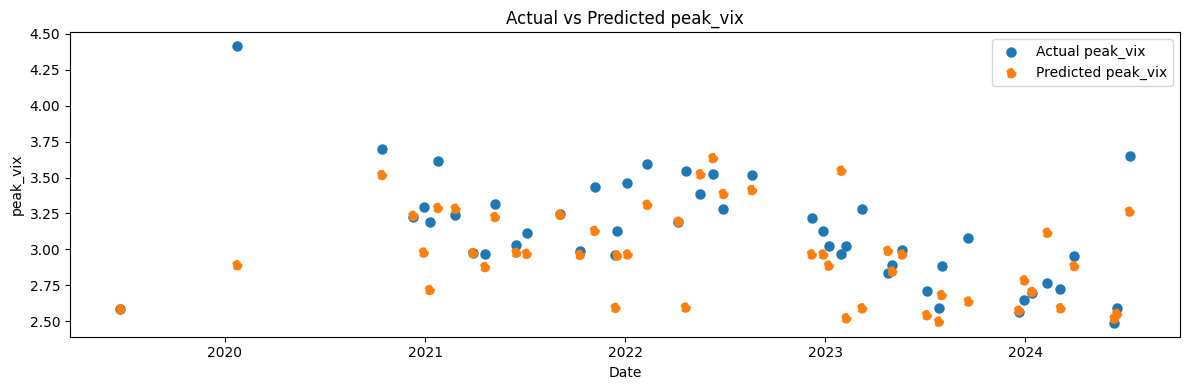

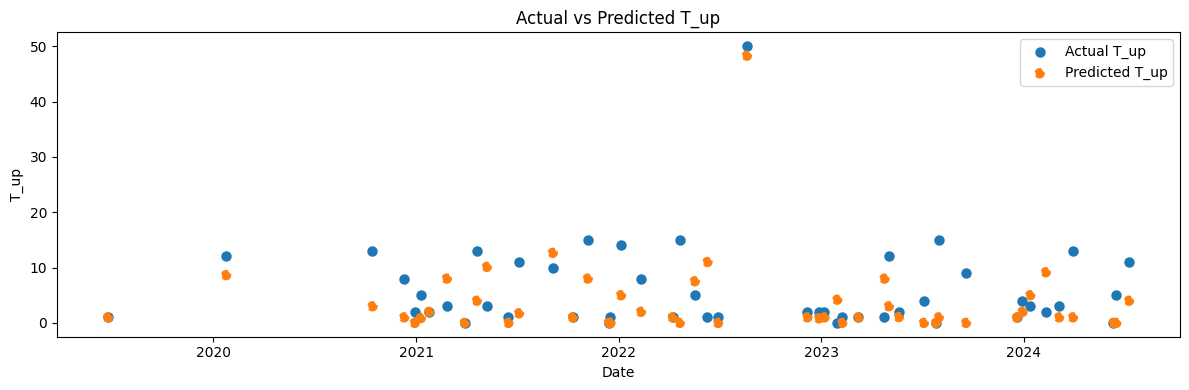

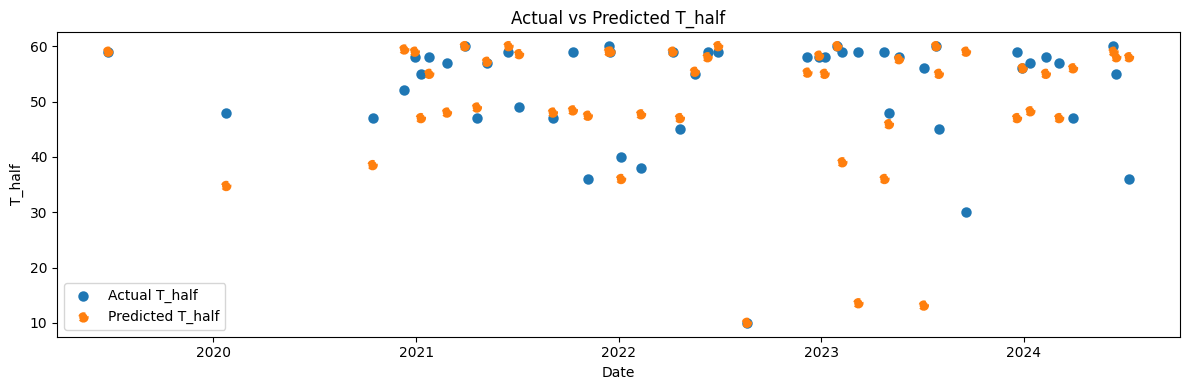

In [2075]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true = arc_df[target].values
    y_pred = model.predict(X_full)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()

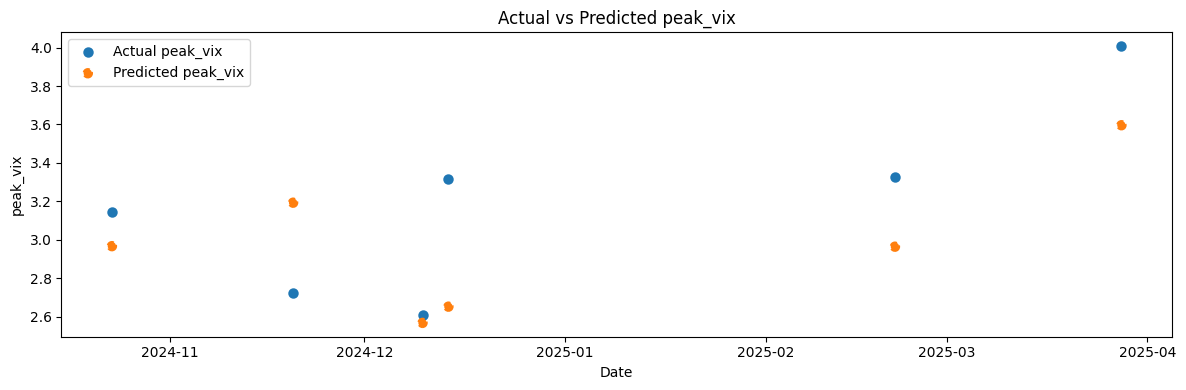

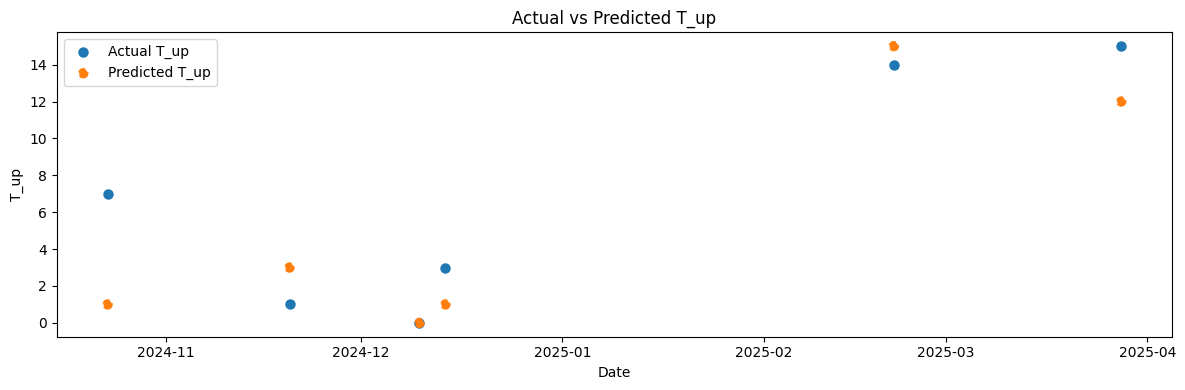

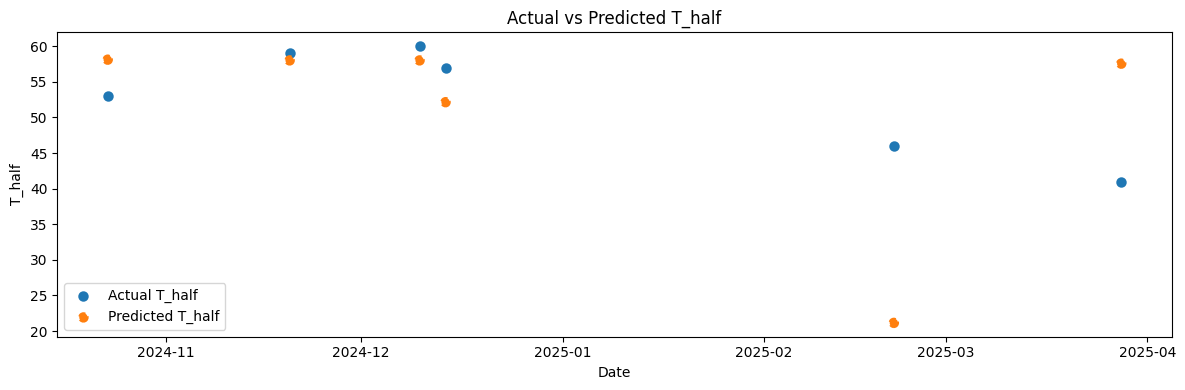

In [2076]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full_test = arc_df_test.reindex(columns=feature_cols).values

dates = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# XGBoost

In [2807]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_pinball_loss
from xgboost import XGBRegressor

# Define targets and features
target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df.columns.difference(target_cols)

# XGBoost parameters (adjust as needed)

xgb_params = {
    "n_estimators": 150,           # very few trees
    "max_depth": 2,               # extremely shallow
    "learning_rate": 0.05,        # slow learning
    "subsample": 0.6,             # random row sampling
    "colsample_bytree": 0.6,      # random feature sampling
    "reg_alpha": 1,             # strong L1 regularization
    "reg_lambda": 5,            # strong L2 regularization
    "random_state": 42,
    "gamma": 0.1,
    "mean_child_weight": 2,
}
quantile_level = 0.65   # e.g. 0.5 for median regression
xgb_params.update({
    "objective":     "reg:quantileerror",  # tell XGBoost to use pinball loss :contentReference[oaicite:0]{index=0}
    "quantile_alpha": quantile_level,      # which quantile to predict :contentReference[oaicite:1]{index=1}
})

# ============================================================
# 1)  INPUT MATRICES & CV SPLIT
# ============================================================
X_full = arc_df[feature_cols].values
y_full = arc_df[target_cols].values
tscv   = TimeSeriesSplit(n_splits=10)

pinball_scorer = make_scorer(
    mean_pinball_loss,
    greater_is_better=False,
    alpha=quantile_level
)
# ============================================================
# 2)  TRAIN PER‑TARGET WITH y‑SCALING
# ============================================================
models, cv_mae = {}, {}

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    # pipeline: X‑scaler → XGBoost, plus y‑scaler wrapper
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("xgb",     XGBRegressor(**xgb_params)),
    ])
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=StandardScaler()     # scales y
    )

    # walk‑forward CV
    cv = cross_validate(
        pipe, X_full, y,
        cv=tscv,
        scoring=pinball_scorer,
        n_jobs=-1,
        return_train_score=False
    )
    cv_mae[col] = -cv["test_score"].mean()
    print(f"{col:8s} | MAE (5-fold): {cv_mae[col]:.3f}")

    # fit on all data & save
    pipe.fit(X_full, y)
    models[col] = pipe
    joblib.dump(pipe, f"xgb_{col}.pkl")

print("\nSaved pickled models:", [f"xgb_{c}.pkl" for c in target_cols])

# ============================================================
# 3)  HELPER FOR NEW PREDICTIONS
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    returns dict {target: prediction}
    """
    preds = {
        col: float(models[col].predict(row_df[feature_cols].values))
        for col in target_cols
    }
    return preds

# Example:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:26:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "mean_child_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:26:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "mean_child_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:26:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "mean_child_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:26:23] WARNING: /Users/runner/w

peak_vix | MAE (5-fold): 0.114
T_up     | MAE (5-fold): 3.188
T_half   | MAE (5-fold): 3.118

Saved pickled models: ['xgb_peak_vix.pkl', 'xgb_T_up.pkl', 'xgb_T_half.pkl']


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:26:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "mean_child_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:26:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "mean_child_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:26:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "mean_child_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:26:23] WARNING: /Users/runner/w

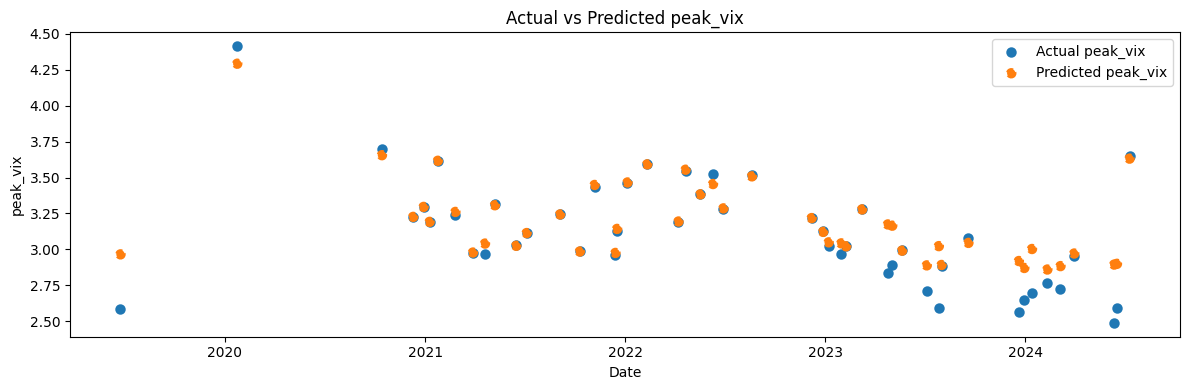

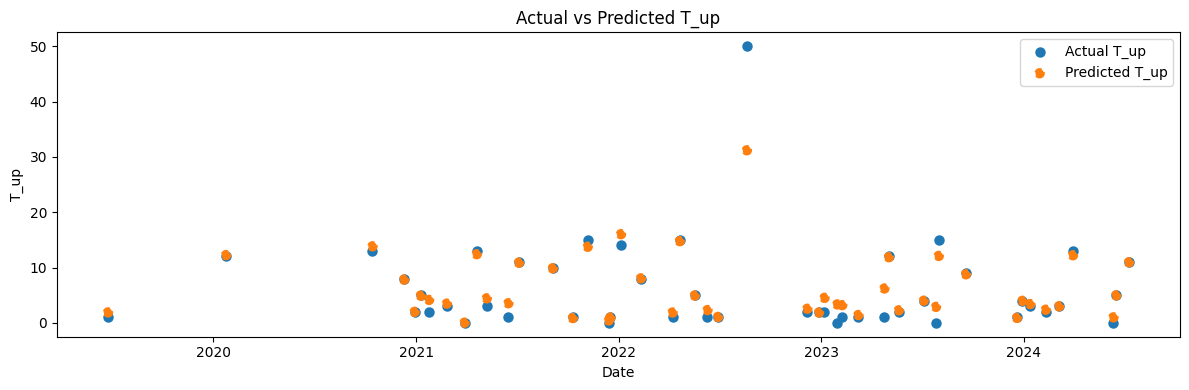

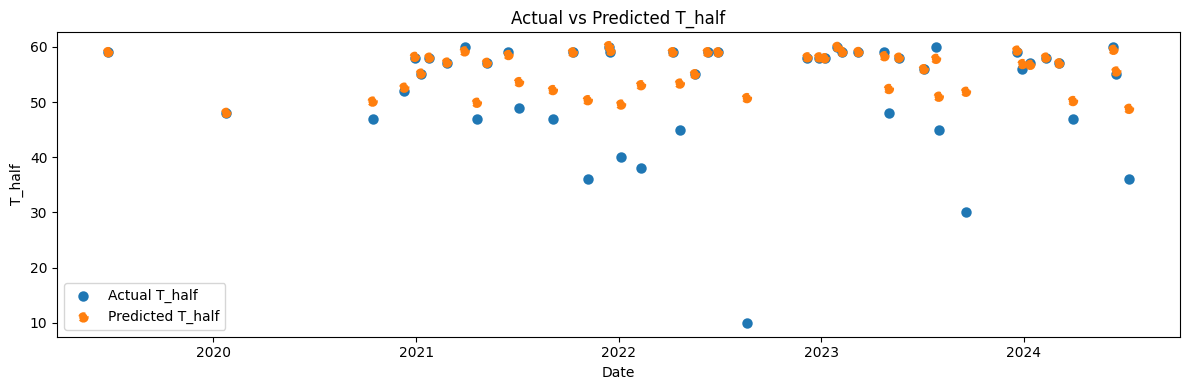

In [2808]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index         # x‑axis

models = {
    "peak_vix": joblib.load("xgb_peak_vix.pkl"),
    "T_up":     joblib.load("xgb_T_up.pkl"),
    "T_half":   joblib.load("xgb_T_half.pkl"),
}

for target, model in models.items():
    y_true = arc_df[target].values
    y_pred = model.predict(X_full)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


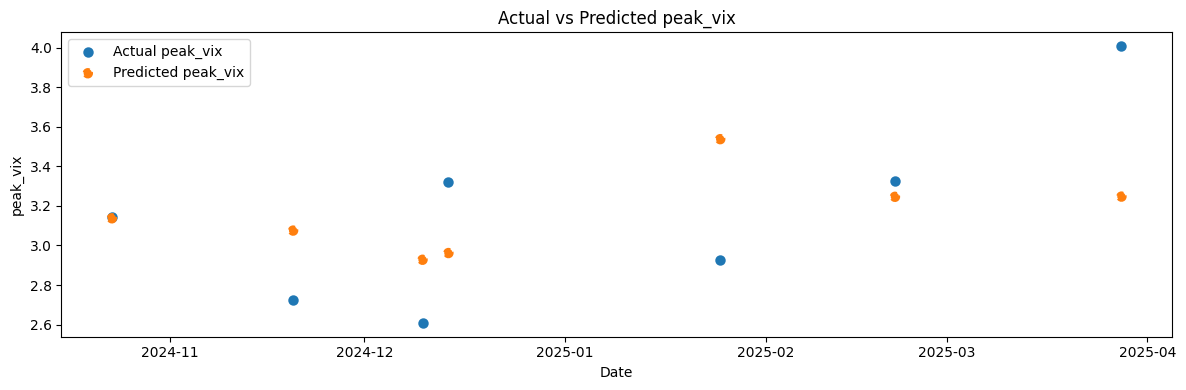

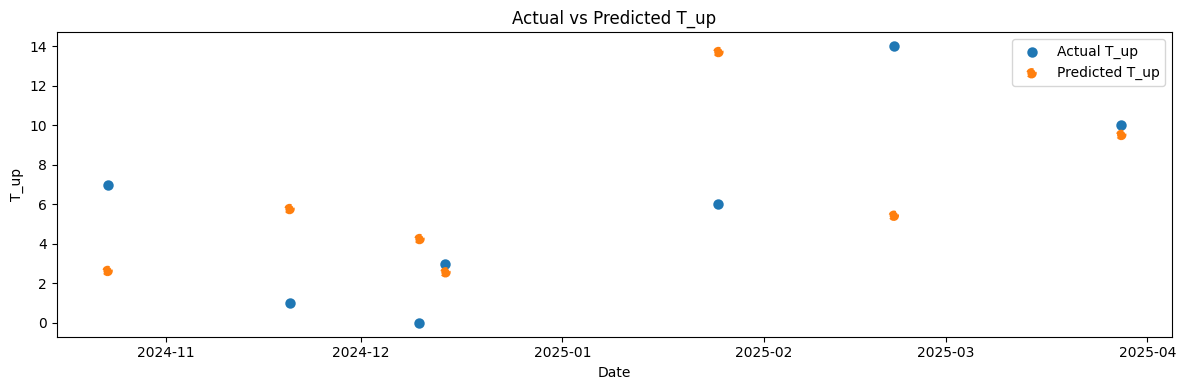

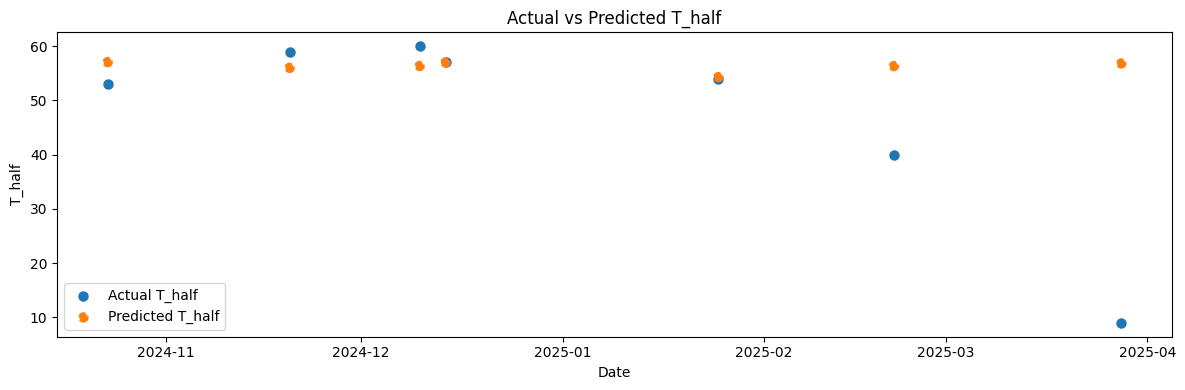

In [2809]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half"])
X_full_test       = arc_df_test[feature_cols].values
dates        = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("xgb_peak_vix.pkl"),
    "T_up":     joblib.load("xgb_T_up.pkl"),
    "T_half":   joblib.load("xgb_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Test Set on models (regime + panic probability)


In [1760]:
vix_windows_df_train.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2019-05-09,3.022861,2.893700,2.799717,2.770086,2.704711,2.763170,2.768204,2.766948,2.726545,2.731115,...,2.540026,2.554122,2.574900,2.535283,2.535283,2.770086,2.694627,2.536075,2.496506,NaN
2019-06-25,2.785628,2.586259,2.567254,2.559550,2.604909,2.604909,2.551786,3.202340,3.202340,2.827905,...,2.553344,2.553344,2.558002,2.563410,2.678278,2.789937,2.888704,2.710713,2.696652,NaN
2019-08-04,3.202340,2.827905,3.048799,2.863343,3.053057,2.916148,2.961141,2.961141,3.011113,2.962692,...,2.696652,2.696652,2.665838,2.837908,3.326833,3.509154,3.736240,3.856510,3.987131,0.1650
2019-10-07,2.925310,2.866193,2.745988,2.678965,2.671386,2.537657,2.573375,2.573375,2.509599,2.572612,...,3.780319,3.815732,3.581573,3.505257,3.514824,3.316728,3.497719,3.563316,3.331847,0.1850
2019-12-03,2.694627,2.536075,2.496506,2.695978,2.598979,2.516890,2.553344,2.553344,2.553344,2.558002,...,3.445852,3.521644,3.547604,3.415429,3.354106,3.330059,3.251924,3.120160,3.096934,0.7775


In [1761]:
print(results.params)

p[0->0]     0.930010
p[1->0]     0.083439
p[2->0]     0.000871
p[0->1]     0.062174
p[1->1]     0.842304
p[2->1]     0.150584
const[0]   -0.595807
const[1]    0.228965
const[2]    1.793575
x1[0]       0.204526
x1[1]       0.223106
x1[2]       0.565556
x2[0]       0.019885
x2[1]       0.066159
x2[2]       0.233569
sigma2      0.177738
dtype: float64


In [1762]:
# 1. After fitting on training set
train_params = results.params


X_test = test_df[selected_features]
y_test = test_df['vix_ewm_zscore']

# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=3,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities.idxmax(axis=1)
test_df['regime_t'] = test_df['regime_t_raw'].apply(lambda r: 1 if r in [1, 2] else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)



/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/1962623518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities.idxmax(axis=1)
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/1962623518.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [1763]:
test_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std,vix_ewm_zscore,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,11.605613,-0.001535,1,1,0.593901,3.430432,15,True,1.0,False
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,11.198272,-0.001481,1,1,0.569931,3.430432,15,True,1.0,False
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,10.805228,-0.001429,1,1,0.554937,3.405189,15,True,1.0,False
2025-04-15,-0.174286,-0.975042,117,-0.138407,-0.974432,195,103,-0.156347,-0.974737,376,...,10.427948,-0.070126,1,1,0.530350,3.485539,15,True,1.0,False
2025-04-16,-0.254442,-0.974785,169,-0.164961,-0.974998,247,127,-0.209701,-0.974891,452,...,10.072522,0.165338,1,1,0.441346,NaN,15,True,1.0,False


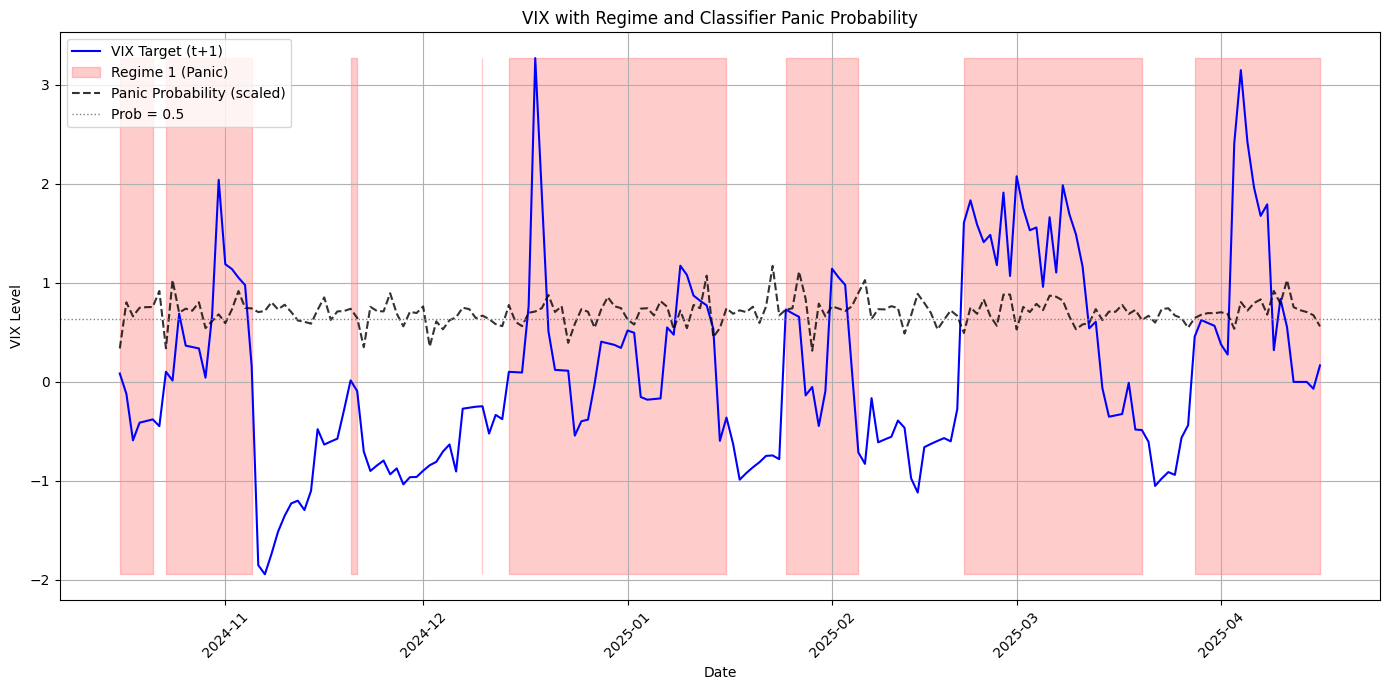

In [2743]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_ewm_zscore"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_ewm_zscore"].min(),
    test_df["vix_ewm_zscore"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_ewm_zscore"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_ewm_zscore"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

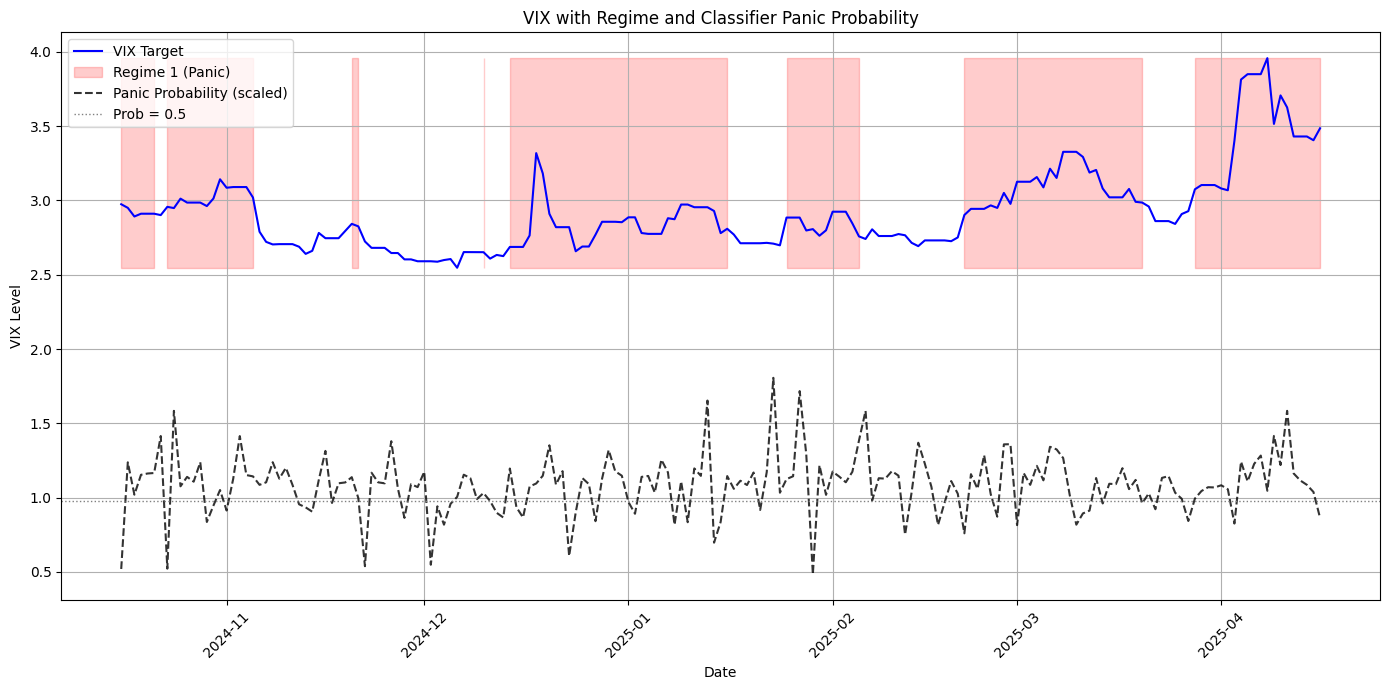

In [2744]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target"], label="VIX Target", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target"].min(),
    test_df["vix_target"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2745]:
test_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std,vix_ewm_zscore,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,2.237779,0.083744,1,1,0.265752,2.950212,1,True,NaN,False
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,2.160467,-0.121784,1,1,0.632301,2.892037,1,True,1.0,False
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,2.113252,-0.591733,1,1,0.521093,2.910719,1,True,1.0,False
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,2.052570,-0.412989,1,1,0.589433,2.910719,1,True,1.0,False
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,1.992570,-0.396085,1,1,0.593901,2.910719,1,True,1.0,False


In [2746]:
classification_df_test = macro_utils.identify_sustained_regimes_and_transitions(test_df)

/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['regime_group'] = (classification_df['regime_t'] != classification_df['regime_t'].shift()).cumsum()
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['is_sustained_regime1'] = classification_df['regime_group'].isin(valid_groups)
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_u

In [2747]:
classification_df_test

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std,vix_ewm_zscore,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,2.237779,0.083744,1,1,0.265752,2.950212,1,True,NaN,False
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,2.160467,-0.121784,1,1,0.632301,2.892037,1,True,1.0,False
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,2.113252,-0.591733,1,1,0.521093,2.910719,1,True,1.0,False
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,2.052570,-0.412989,1,1,0.589433,2.910719,1,True,1.0,False
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,1.992570,-0.396085,1,1,0.593901,2.910719,1,True,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,11.605613,-0.001535,1,1,0.593901,3.430432,15,True,1.0,False
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,11.198272,-0.001481,1,1,0.569931,3.430432,15,True,1.0,False
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,10.805228,-0.001429,1,1,0.554937,3.405189,15,True,1.0,False


In [2748]:
result = macro_utils.transform_vix_data(classification_df_test, window=60, test=True)
vix_windows_df_test = result["vix_windows_df_train"]
regime_windows_df_test = result["regime_windows_df_train"]
vix_windows_past_df_test = result["vix_windows_past_df_train"]

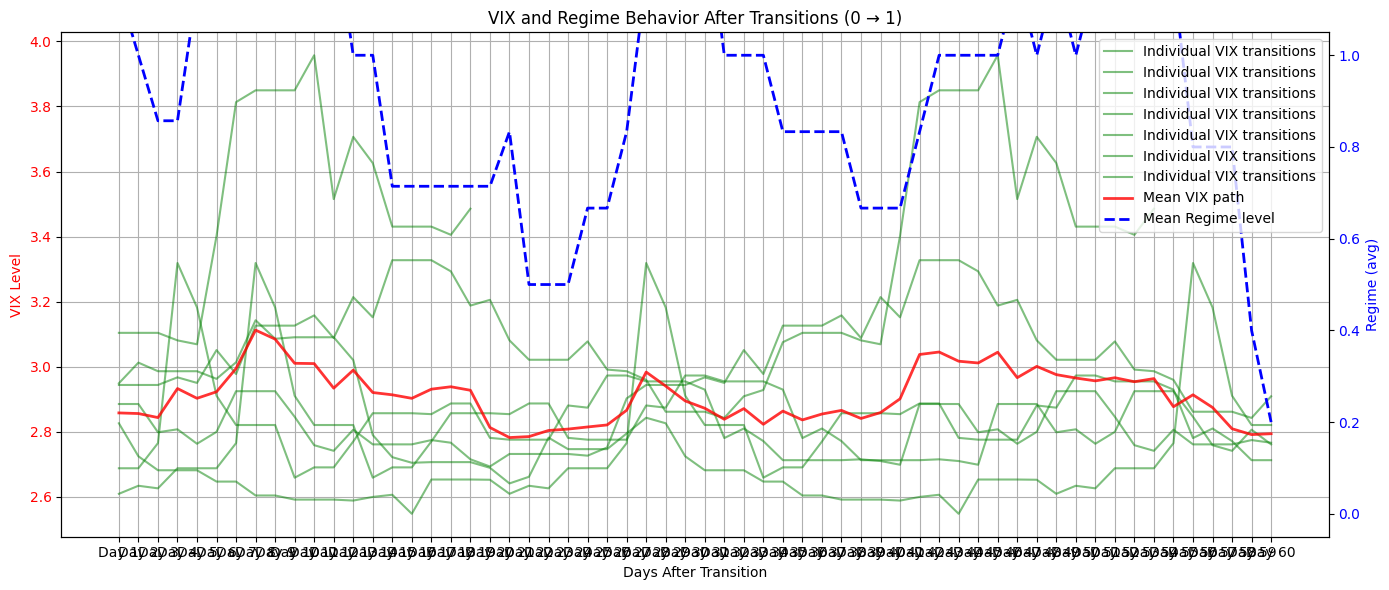

In [2749]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_test.T, color="green", alpha=0.5, label="Individual VIX transitions")
ax1.plot(vix_windows_df_test.mean(axis=0).values, color="red",alpha=0.8, linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_test.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()


In [2750]:
vix_windows_df_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-23,2.948641,3.012098,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,...,2.625393,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188
2024-11-20,2.825537,2.723924,2.681022,2.681022,2.681022,2.646175,2.646175,2.603430,2.603430,2.590767,...,2.972464,2.954389,2.954389,2.954389,2.929058,2.780061,2.809403,2.770712,2.712042,2.712042
2024-12-10,2.608598,2.633327,2.625393,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,...,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643
2024-12-14,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,...,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690
2025-01-25,2.884801,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,...,3.020913,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539
2025-02-21,2.943386,2.943386,2.943386,2.966818,2.949688,3.050694,2.977059,3.125883,3.125883,3.125883,...,3.430432,3.430432,3.405189,3.485539,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-28,3.103689,3.103689,3.103689,3.080533,3.068518,3.401864,3.813528,3.849722,3.849722,3.849722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2751]:
df_delayed_spike_prob_test, test_clf, test_vix_pct_change_lookback_df = macro_utils.clf_delayed_spike_prob(vix_windows_df_test, test_df, "vix_target")

In [2752]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-23,2.948641,3.012098,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,...,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,NaN
2024-11-20,2.825537,2.723924,2.681022,2.681022,2.681022,2.646175,2.646175,2.603430,2.603430,2.590767,...,2.954389,2.954389,2.954389,2.929058,2.780061,2.809403,2.770712,2.712042,2.712042,NaN
2024-12-10,2.608598,2.633327,2.625393,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,...,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,0.87
2024-12-14,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,...,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,0.91
2025-01-25,2.884801,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,...,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,NaN


In [2753]:
test_vix_pct_change_lookback_df.head()

,Day -30,Day -29,Day -28,Day -27,Day -26,Day -25,Day -24,Day -23,Day -22,Day -21,...,Day -10,Day -9,Day -8,Day -7,Day -6,Day -5,Day -4,Day -3,Day -2,Day -1
2024-12-10,0.000000,0.000000,-0.006475,-0.017869,0.007754,0.045225,-0.012696,0.000000,0.000000,0.017567,...,-0.004864,0.000000,0.000000,-0.001159,0.004334,0.002566,-0.022470,0.041396,0.000000,0.000000
2024-12-14,0.007754,0.045225,-0.012696,0.000000,0.000000,0.017567,0.017305,-0.005996,-0.035963,-0.015750,...,0.004334,0.002566,-0.022470,0.041396,0.000000,0.000000,-0.000266,-0.016304,0.009480,-0.003013
2025-02-21,0.000978,-0.001957,-0.004201,0.069237,0.000000,0.000000,-0.030127,0.003252,-0.015836,0.013238,...,0.004780,-0.002937,-0.018439,-0.008140,0.014305,0.000000,0.000000,0.000000,-0.001913,0.009252
2025-03-28,-0.005774,0.034243,-0.024137,0.049990,0.000000,0.000000,0.010091,-0.022034,0.040742,-0.019358,...,0.018670,-0.028139,-0.001684,-0.008914,-0.033122,0.000000,0.000000,-0.006662,0.023413,0.006687


In [2754]:
df_delayed_spike_prob_test.loc[test_vix_pct_change_lookback_df.index, "early_spike_prob"] = clf_delayed_spike_prob.predict_proba(test_vix_pct_change_lookback_df)[:, 1]


In [2755]:
df_delayed_spike_prob_test.fillna(0.5, inplace=True)

In [2756]:
df_delayed_spike_prob_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-23,2.948641,3.012098,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,...,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,0.5000
2024-11-20,2.825537,2.723924,2.681022,2.681022,2.681022,2.646175,2.646175,2.603430,2.603430,2.590767,...,2.954389,2.954389,2.954389,2.929058,2.780061,2.809403,2.770712,2.712042,2.712042,0.5000
2024-12-10,2.608598,2.633327,2.625393,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,...,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,0.3525
2024-12-14,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,...,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,0.5350
2025-01-25,2.884801,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,...,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,0.5000
2025-02-21,2.943386,2.943386,2.943386,2.966818,2.949688,3.050694,2.977059,3.125883,3.125883,3.125883,...,3.430432,3.405189,3.485539,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.4825
2025-03-28,3.103689,3.103689,3.103689,3.080533,3.068518,3.401864,3.813528,3.849722,3.849722,3.849722,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.5375


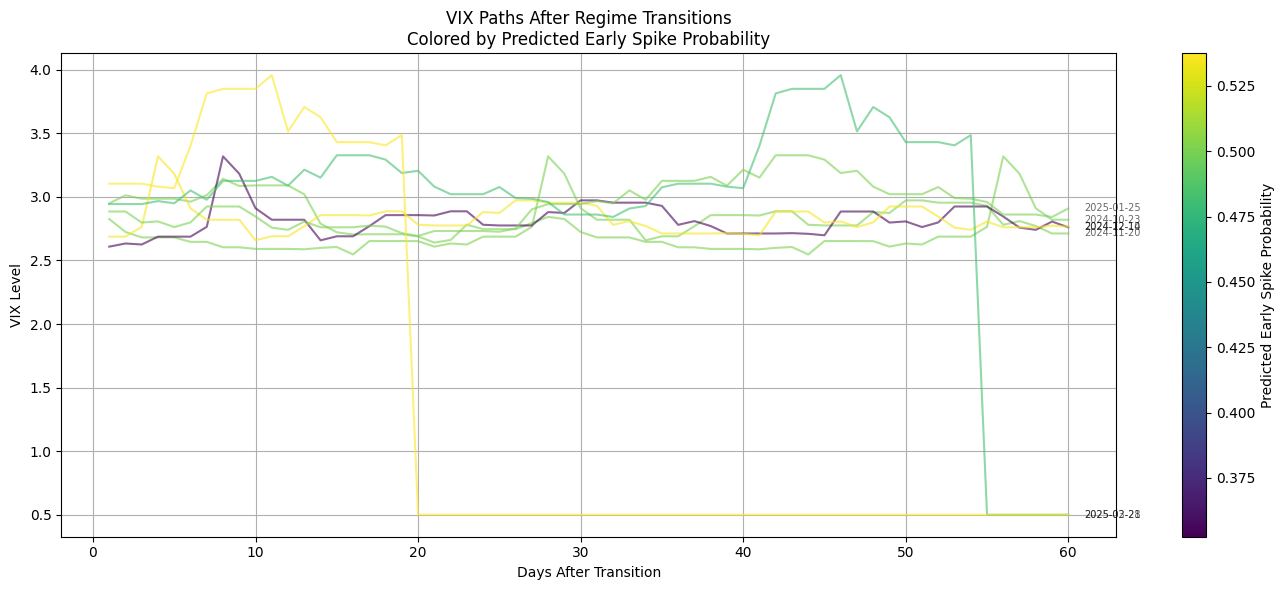

In [2770]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob_test.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [2771]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-23,2.948641,3.012098,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,...,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,0.5000
2024-11-20,2.825537,2.723924,2.681022,2.681022,2.681022,2.646175,2.646175,2.603430,2.603430,2.590767,...,2.954389,2.954389,2.954389,2.929058,2.780061,2.809403,2.770712,2.712042,2.712042,0.5000
2024-12-10,2.608598,2.633327,2.625393,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,...,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,0.3525
2024-12-14,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,...,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,0.5350
2025-01-25,2.884801,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,...,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,0.5000


In [2772]:
regime_windows_df_test = regime_windows_df_test.replace(2, 1)


In [2773]:
regime_windows_df_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-11-20,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2024-12-10,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2024-12-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2025-02-21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2025-03-28,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2774]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = test_df.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_test = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_test.index = pd.to_datetime(news_feats_test.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_test.index.min(),
                          news_feats_test.index.max(),
                          freq='D')

news_dense_test = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



In [2775]:
# ------------------------------------------------------------
# 3)  BUILD ARC-LEVEL TABLE  (robust to missing news dates + look-back stats)
# ------------------------------------------------------------
records = []
lookback_days = [2, 5, 7]
lookback_feats = [
    "shock_neg",
    "vix_zscore",
    "vix_target",
    "sentiment_dominance",
]

for dt, row in vix_windows_df_test.iterrows():
    # --- detect arc in the 60-day window ---
    v = row[[f"Day {i}" for i in range(1, 61)]].values
    r = regime_windows_df_test.loc[dt, [f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur = peak_idx - start_idx
    decay_idx = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest-past news features --------
    try:
        feats_on_start = news_dense_test.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    # -------- compute look-back statistics from classification_df --------
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df_test.loc[start_date:dt_norm]

        for feat in lookback_feats:
            col_mean = window_df[feat].mean()
            col_std = window_df[feat].std()
            # percent change over the window: (last−first) / first
            if len(window_df) > 1 and window_df[feat].iloc[0] != 0:
                col_pct = (window_df[feat].iloc[-1] - window_df[feat].iloc[0]) / window_df[feat].iloc[0]
            else:
                col_pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"] = col_mean
            lookback_stats[f"{feat}_std_{w}d"]  = col_std
            lookback_stats[f"{feat}_pctchg_{w}d"] = col_pct

    # --- aggregate everything into one record ---
    records.append({
        "date_start":    dt_norm,
        "peak_vix":      peak_val,
        "vix0":          start_val,
        "T_up":          rise_dur,
        "T_half":        half_life,
        **feats_on_start,
        **lookback_stats,
    })

arc_df_test = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)


arc_df shape: (48, 63)


/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:348: RuntimeWarning: invalid value encountered in cast
  r = np.asarray(regime_path, dtype=np.int8)
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:348: RuntimeWarning: invalid value encountered in cast
  r = np.asarray(regime_path, dtype=np.int8)


In [2776]:
arc_df_test['early_spike_prob'] = vix_windows_df_test['early_spike_prob'].fillna(0.5)

In [2777]:
# Get column sets
cols_arc_df = set(arc_df.columns)
cols_arc_df_test = set(arc_df_test.columns)

# Columns in arc_df but NOT in arc_df_test
diff_arc_not_test = cols_arc_df - cols_arc_df_test

# Columns in arc_df_test but NOT in arc_df
diff_test_not_arc = cols_arc_df_test - cols_arc_df

# All differing columns
diff_all = cols_arc_df.symmetric_difference(cols_arc_df_test)

# Print results
print("Columns in arc_df but not in arc_df_test:", diff_arc_not_test)
print("Columns in arc_df_test but not in arc_df:", diff_test_not_arc)
print("All differing columns:", diff_all)


Columns in arc_df but not in arc_df_test: set()
Columns in arc_df_test but not in arc_df: {'vix_target', 'regime_t', 'regime_group', 'panic_prob_t+1', 'is_sustained_regime1', 'regime_t-1', 'is_transition', 'vix_target_t+1', 'regime_t_raw'}
All differing columns: {'vix_target', 'is_sustained_regime1', 'regime_t-1', 'regime_t_raw', 'regime_group', 'regime_t', 'panic_prob_t+1', 'is_transition', 'vix_target_t+1'}


In [2778]:
arc_df_test.drop(columns=diff_all, inplace=True)

In [2779]:
arc_df_test['peak_vix'].iloc[-1] = np.log(55)

/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/3418063507.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  arc_df_test['peak_vix'].iloc[-1] = np.log(55)


In [2787]:
arc_df_test.tail()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob
date_start,,,,,,,,,,,,,,,,,,,,,
2024-12-10,2.608598,2.608598,0.0,60.0,-0.144333,-0.975175,100.0,-0.060879,-0.973924,182.0,...,-0.753966,0.502880,-0.705416,2.618617,0.039957,0.024758,74.250,28.858027,-0.325843,0.3525
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,-0.358069,0.283013,-1.605554,2.645491,0.023419,0.013055,63.125,29.112773,-0.220000,0.5350
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,-0.979089,0.654743,-1.455344,2.731881,0.062000,0.063700,8.500,15.212777,-0.454545,0.5000
2025-02-21,3.327192,2.943386,14.0,40.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,-0.451964,0.837399,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231,0.4825
2025-03-28,4.007333,3.103689,10.0,9.0,-0.162400,-0.970411,129.0,-0.077482,-0.974197,228.0,...,-1.087851,0.491524,-0.937639,2.911971,0.077219,0.039180,77.625,38.059868,-0.241758,0.5375


In [2781]:
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])


In [2782]:
arc_df_test['early_spike_prob'] = arc_df_test['early_spike_prob'].fillna(0.5)

In [2783]:
print(list(feature_cols))
print(list(arc_df_test.reindex(columns=feature_cols).columns))


['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_std', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_mean_7d', 'vix_target_pctchg_2d', 'vix_target_pctchg_5d', 'vix_target_pctchg_7d', 'vi

In [2784]:
arc_df_test.iloc[-1]

peak_vix                          4.007333
vix0                              3.103689
T_up                             10.000000
T_half                            9.000000
summary_mean                     -0.162400
                                   ...    
vix_target_pctchg_7d              0.039180
sentiment_dominance_mean_7d      77.625000
sentiment_dominance_std_7d       38.059868
sentiment_dominance_pctchg_7d    -0.241758
early_spike_prob                  0.537500
Name: 2025-03-28 00:00:00, Length: 63, dtype: float64

dom_0                            0
dom_1                            0
dominance_trigger                0
early_spike_prob                 0
ewm_mean                         0
ewm_std                          0
headline_mean                    0
headline_min                     0
headline_neg_count               0
headline_pos_count               0
mean_sentiment_decay             0
overall_mean                     0
overall_min                      0
overall_neg_count                0
overall_pos_count                0
sentiment_dominance              0
sentiment_dominance_mean_2d      0
sentiment_dominance_mean_5d      0
sentiment_dominance_mean_7d      0
sentiment_dominance_pctchg_2d    0
sentiment_dominance_pctchg_5d    1
sentiment_dominance_pctchg_7d    0
sentiment_dominance_std_2d       0
sentiment_dominance_std_5d       0
sentiment_dominance_std_7d       0
shock_neg                        0
shock_neg_mean_2d                0
shock_neg_mean_5d                0
shock_neg_mean_7d   

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


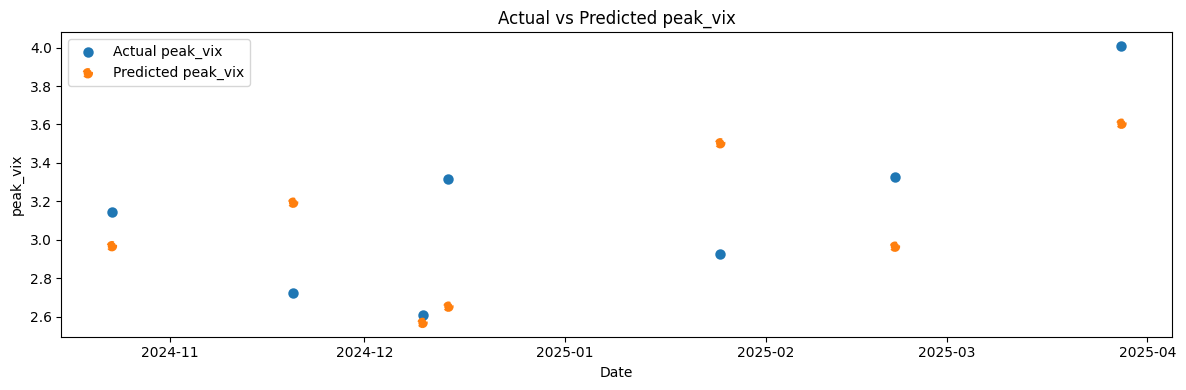

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


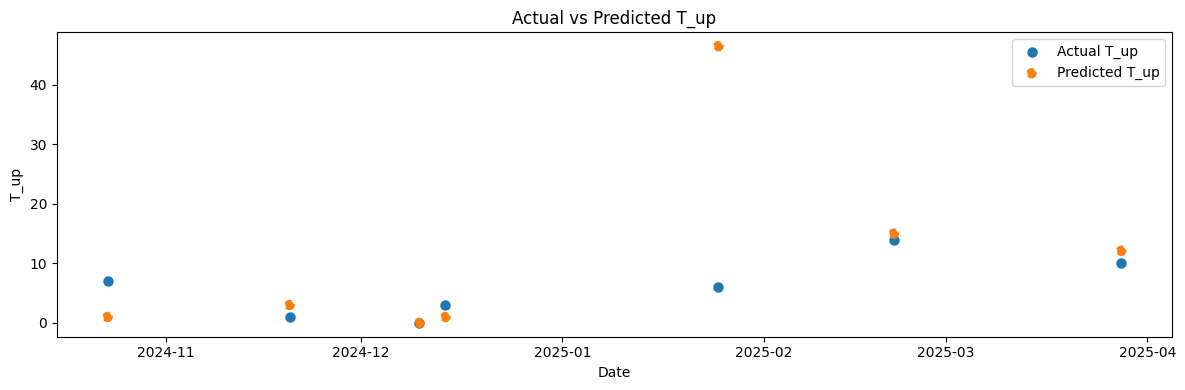

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


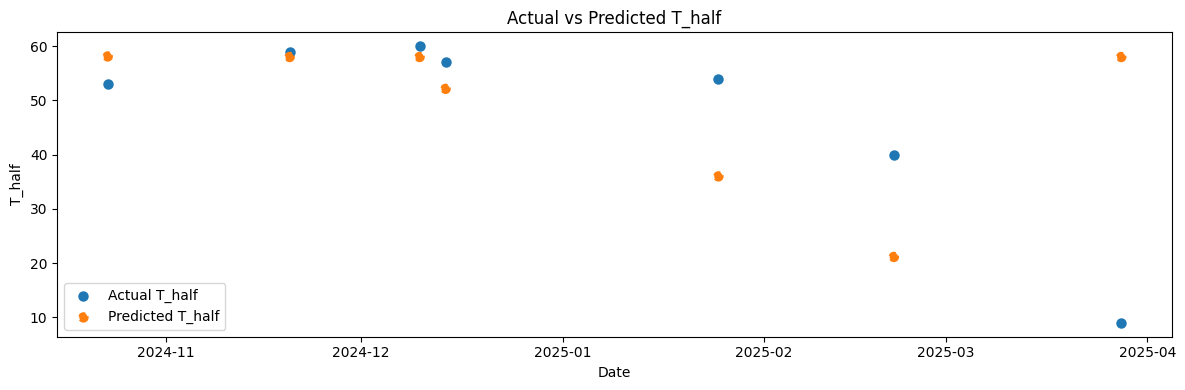

In [2810]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])

X_full_test = arc_df_test.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# XGBoost graph

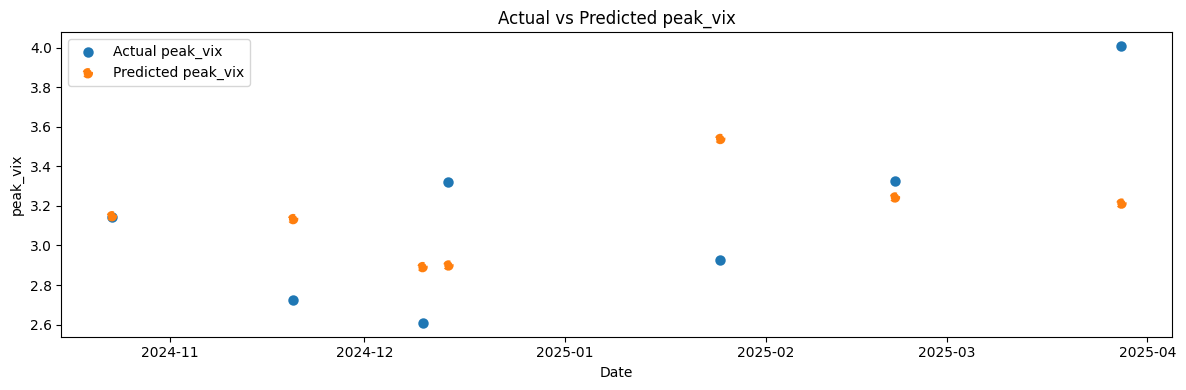

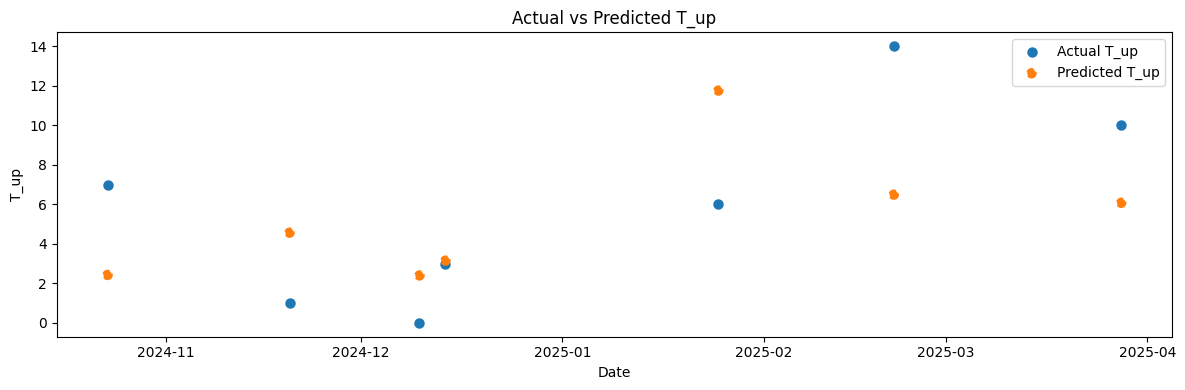

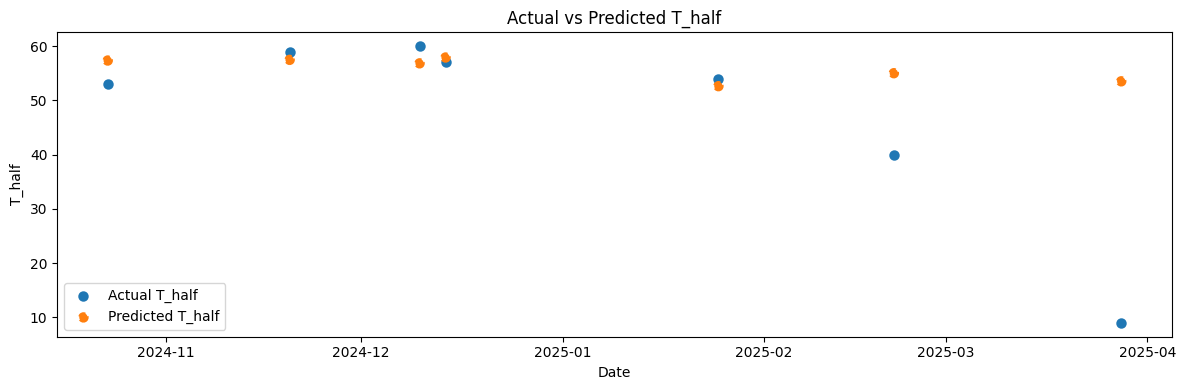

In [2794]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half"])
X_full_test       = arc_df_test[feature_cols].values
dates        = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("xgb_peak_vix.pkl"),
    "T_up":     joblib.load("xgb_T_up.pkl"),
    "T_half":   joblib.load("xgb_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# RECENT/TRADE

In [2456]:
arc_df_test.head()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,shock_neg_pctchg_7d,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-23,3.142427,2.948641,7.0,53.0,-0.157935,-0.975736,40.0,-0.038889,-0.971612,60.0,...,0.000107,-0.059311,0.263105,-0.787686,2.925916,0.030137,-0.005889,2.875,10.260013,-3.000000
2024-11-20,2.723924,2.825537,1.0,59.0,-0.033441,-0.974451,53.0,0.014901,-0.973305,105.0,...,0.000348,-0.972874,0.493275,-0.847446,2.744690,0.066817,0.076538,33.875,17.963753,0.538462
2024-12-10,2.608598,2.608598,0.0,60.0,-0.144333,-0.975175,100.0,-0.060879,-0.973924,182.0,...,-0.001119,-0.753966,0.502880,-0.705416,2.618617,0.039957,0.024758,74.250,28.858027,-0.325843
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,-0.009575,-0.358069,0.283013,-1.605554,2.645491,0.023419,0.013055,63.125,29.112773,-0.220000
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,-0.122846,-0.979089,0.654743,-1.455344,2.731881,0.062000,0.063700,8.500,15.212777,-0.454545


In [2457]:
test_df_trade

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_target,mean_sentiment_decay,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,2.974509,-0.226288,-0.973569,-3,0,0.016615,0.412830,19.392600,2.237779,0.083744
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,2.950212,-0.195090,-0.974176,8,0,0.011111,0.193659,19.373110,2.160467,-0.121784
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,2.892037,-0.248568,-0.972349,-4,0,-0.120059,-0.260678,19.280482,2.113252,-0.591733
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,2.910719,-0.229274,-0.920584,7,0,-0.043727,-0.148076,19.217690,2.052570,-0.412989
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,2.910719,0.012432,-0.949775,7,0,-0.188604,-0.183860,19.159229,1.992570,-0.396085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,3.430432,-0.304711,-0.949604,47,0,0.426790,0.340215,30.907810,11.605613,-0.001535
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,3.430432,-0.049076,-0.970495,43,0,0.386445,0.313508,30.906581,11.198272,-0.001481
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,3.430432,-0.122375,-0.972986,116,0,0.386445,0.283756,30.905438,10.805228,-0.001429


In [2458]:
def get_past_60_trading_days(df, target_date):
    """
    Given a DataFrame with a DatetimeIndex and a target date (string or datetime),
    return the 60 trading days *before* that date (exclusive).
    """
    # Ensure datetime format
    target_date = pd.to_datetime(target_date)
    
    # Filter to dates strictly before the target date
    df_before = df[df.index < target_date]
    
    # Get last 60 rows before the target date
    return df_before.tail(61)


In [2699]:
df_trade = get_past_60_trading_days(test_df_trade, "2024-12-14")

In [2700]:
df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_target,mean_sentiment_decay,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore
date,,,,,,,,,,,,,,,,,,,,,
2024-12-09,0.042288,-0.973634,63,-0.042489,-0.971553,193,53,-0.000100,-0.972594,376,...,2.652537,-0.125769,-0.972594,120,0,-0.028082,-0.309846,14.708927,2.061672,-0.251702
2024-12-10,-0.144333,-0.975175,100,-0.060879,-0.973924,182,78,-0.102606,-0.974550,342,...,2.651833,-0.000100,-0.974550,60,0,-0.028767,-0.295634,14.672450,1.993987,-0.246967
2024-12-11,-0.024597,-0.973637,107,-0.014560,-0.971444,214,89,-0.019578,-0.972541,410,...,2.608598,-0.102606,-0.972541,89,0,-0.036879,-0.782323,14.597108,1.944543,-0.523058
2024-12-12,-0.075603,-0.973693,91,-0.009159,-0.972878,170,73,-0.042381,-0.973286,322,...,2.633327,-0.019578,-0.973286,61,0,-0.012766,-0.457400,14.550411,1.884410,-0.334540
2024-12-13,-0.164213,-0.974127,81,-0.112501,-0.972634,155,65,-0.138357,-0.973381,294,...,2.625393,-0.042381,-0.973381,58,0,0.022206,-0.546520,14.499348,1.828280,-0.377047


In [2701]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data

X_test = df_trade[selected_features]
y_test = df_trade['vix_ewm_zscore']


In [2702]:
X_test.tail()

,shock_neg,dominance_trigger
date,,
2024-12-09,-0.972594,0
2024-12-10,-0.974550,0
2024-12-11,-0.972541,0
2024-12-12,-0.973286,0
2024-12-13,-0.973381,0


In [2703]:
# 3. Define same model on test data
model_trade = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=3,
    switching_variance=False
)

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [2704]:
results_test = model_trade.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
df_trade['regime_t_raw'] = results_test.filtered_marginal_probabilities.idxmax(axis=1)
df_trade['regime_t'] = df_trade['regime_t_raw'].apply(lambda r: 1 if r in [1, 2] else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
df_trade['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

In [2705]:
df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,regime_t_raw,regime_t,panic_prob_t+1
date,,,,,,,,,,,,,,,,,,,,,
2024-12-09,0.042288,-0.973634,63,-0.042489,-0.971553,193,53,-0.000100,-0.972594,376,...,120,0,-0.028082,-0.309846,14.708927,2.061672,-0.251702,0,0,0.505970
2024-12-10,-0.144333,-0.975175,100,-0.060879,-0.973924,182,78,-0.102606,-0.974550,342,...,60,0,-0.028767,-0.295634,14.672450,1.993987,-0.246967,1,1,0.526833
2024-12-11,-0.024597,-0.973637,107,-0.014560,-0.971444,214,89,-0.019578,-0.972541,410,...,89,0,-0.036879,-0.782323,14.597108,1.944543,-0.523058,0,0,0.499319
2024-12-12,-0.075603,-0.973693,91,-0.009159,-0.972878,170,73,-0.042381,-0.973286,322,...,61,0,-0.012766,-0.457400,14.550411,1.884410,-0.334540,0,0,0.458810
2024-12-13,-0.164213,-0.974127,81,-0.112501,-0.972634,155,65,-0.138357,-0.973381,294,...,58,0,0.022206,-0.546520,14.499348,1.828280,-0.377047,0,0,0.442721


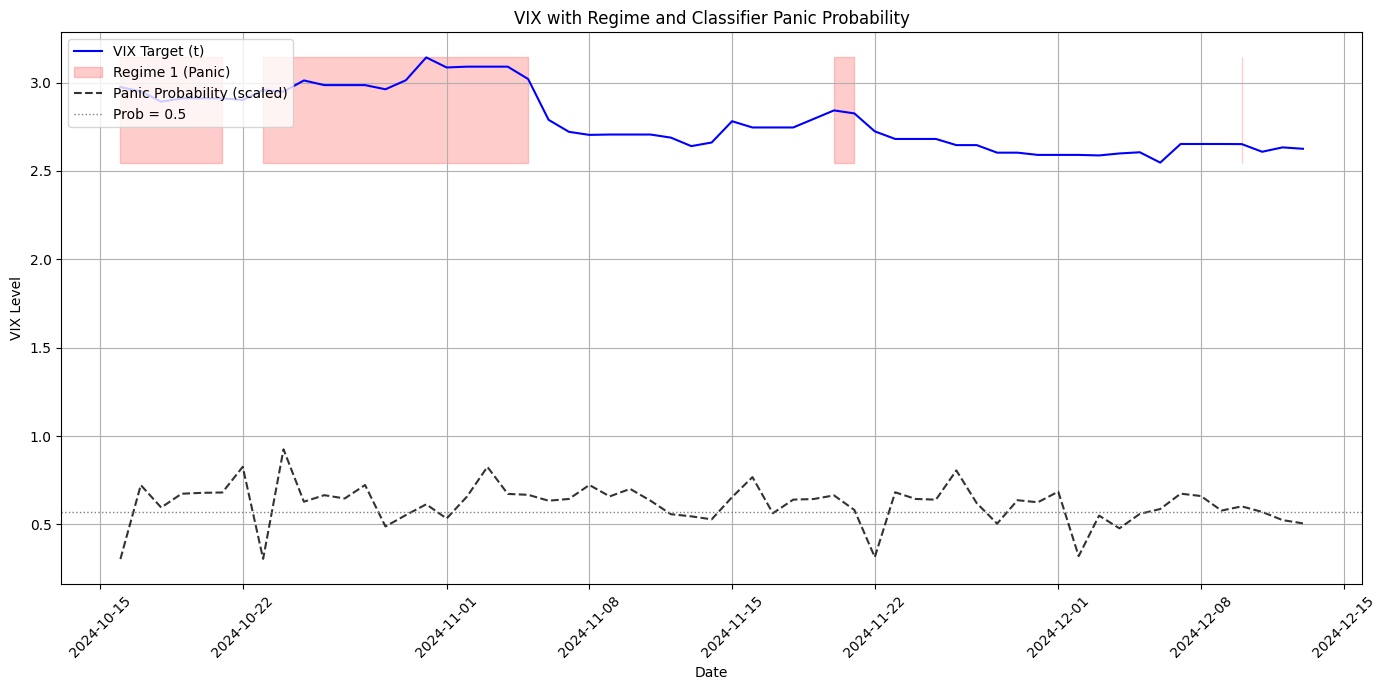

In [2706]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(df_trade.index, df_trade["vix_target"], label="VIX Target (t)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    df_trade.index,
    df_trade["vix_target"].min(),
    df_trade["vix_target"].max(),
    where=df_trade["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = df_trade["panic_prob_t+1"] * (df_trade["vix_target"].max() - 2)
plt.plot(df_trade.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (df_trade["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2707]:
classification_df_trade = macro_utils.identify_sustained_regimes_and_transitions(df_trade, trade = True)

In [2708]:
classification_df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_mean,ewm_std,vix_ewm_zscore,regime_t_raw,regime_t,panic_prob_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-12-09,0.042288,-0.973634,63,-0.042489,-0.971553,193,53,-0.000100,-0.972594,376,...,14.708927,2.061672,-0.251702,0,0,0.505970,6,False,0.0,False
2024-12-10,-0.144333,-0.975175,100,-0.060879,-0.973924,182,78,-0.102606,-0.974550,342,...,14.672450,1.993987,-0.246967,1,1,0.526833,7,True,0.0,True
2024-12-11,-0.024597,-0.973637,107,-0.014560,-0.971444,214,89,-0.019578,-0.972541,410,...,14.597108,1.944543,-0.523058,0,0,0.499319,8,False,1.0,False
2024-12-12,-0.075603,-0.973693,91,-0.009159,-0.972878,170,73,-0.042381,-0.973286,322,...,14.550411,1.884410,-0.334540,0,0,0.458810,8,False,0.0,False
2024-12-13,-0.164213,-0.974127,81,-0.112501,-0.972634,155,65,-0.138357,-0.973381,294,...,14.499348,1.828280,-0.377047,0,0,0.442721,8,False,0.0,False


In [2709]:
result_trade = macro_utils.transform_vix_data(classification_df_trade, window=50, trade = True)
vix_windows_past_df_trade = result_trade["vix_windows_past_df_train"]

In [2710]:
from macro_utils import calculate_pct_changes

# Get current date (your live transition point — usually last row in trade DF)
live_index = classification_df_trade[classification_df_trade["is_transition"]].index[-1:]
print(f"✅ Using live index: {live_index}")

# Calculate past % changes from historical VIX column
vix_pct_change_lookback_df_trade, used_indices = calculate_pct_changes(
    df_model=classification_df_trade,
    valid_indices=live_index,
    lookback=30,
    vix_column="vix_target"
)

# Now predict with  classifier
early_spike_prob_trade = clf_delayed_spike_prob.predict_proba(vix_pct_change_lookback_df_trade)[0][1]
print(f"🟢 Early spike probability: {early_spike_prob_trade:.2%}")


✅ Using live index: DatetimeIndex(['2024-12-10'], dtype='datetime64[ns]', name='date', freq=None)
🟢 Early spike probability: 35.25%


In [2711]:
vix_pct_change_lookback_df_trade.head()

,Day -30,Day -29,Day -28,Day -27,Day -26,Day -25,Day -24,Day -23,Day -22,Day -21,...,Day -10,Day -9,Day -8,Day -7,Day -6,Day -5,Day -4,Day -3,Day -2,Day -1
2024-12-10,0.0,0.0,-0.006475,-0.017869,0.007754,0.045225,-0.012696,0.0,0.0,0.017567,...,-0.004864,0.0,0.0,-0.001159,0.004334,0.002566,-0.02247,0.041396,0.0,0.0


In [2712]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = df_trade.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_trade = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_trade.index = pd.to_datetime(news_feats_trade.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_trade.index.min(),
                          news_feats_trade.index.max(),
                          freq='D')

news_dense_trade = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)

In [2713]:
news_dense_trade.columns

Index(['summary_mean', 'summary_min', 'summary_neg_count', 'headline_mean',
       'headline_min', 'headline_pos_count', 'headline_neg_count',
       'overall_mean', 'overall_min', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'ewm_mean', 'ewm_std', 'vix_ewm_zscore', 'regime_t_raw', 'regime_t',
       'panic_prob_t+1', 'vix_target_t+1', 'regime_group',
       'is_sustained_regime1', 'regime_t-1', 'is_transition', 'dom_0',
       'dom_1'],
      dtype='object')

In [2714]:
feature_cols = feature_cols.drop(['date','date.1'], errors='ignore')


In [2715]:
df_trade.columns

Index(['summary_mean', 'summary_min', 'summary_neg_count', 'headline_mean',
       'headline_min', 'headline_pos_count', 'headline_neg_count',
       'overall_mean', 'overall_min', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'ewm_mean', 'ewm_std', 'vix_ewm_zscore', 'regime_t_raw', 'regime_t',
       'panic_prob_t+1', 'regime_group', 'is_sustained_regime1', 'regime_t-1',
       'is_transition'],
      dtype='object')

In [2716]:
def build_live_arc_row(start_idx,
                       news_dense,
                       classification_df_trade,
                       feature_cols,
                       lookback_days=(2, 5, 7),
                       lookback_feats=("shock_neg", "vix_zscore", "vix_target", "sentiment_dominance")):
    """
    Build one live-arc row of features at timestamp `start_idx`.
    Returns a DataFrame with one row and columns exactly = feature_cols.
    """
    # normalize the timestamp
    dt_norm = pd.to_datetime(start_idx).normalize()

    # --- 1) grab the base row from classification_df_trade ---
    try:
        row = classification_df_trade.loc[[start_idx]].copy()
    except KeyError:
        print(f"❌ No classification data at {start_idx}")
        return None

    # --- 2) pull the latest news features (dropping any 'date' col) ---
    try:
        feats_on_start = (
            news_dense
            .loc[:dt_norm]
            .iloc[-1]
            .drop(labels=["date"], errors="ignore")
            .to_dict()
        )
    except IndexError:
        print(f"❌ No prior news available at {dt_norm}")
        return None

    # --- 3) one-hot encode the 'dominance_trigger' field ---
    dom_dummies = pd.get_dummies(row["dominance_trigger"], prefix="dom")
    # ensure both dom_0 and dom_1 exist
    for col in ("dom_0", "dom_1"):
        dom_dummies[col] = dom_dummies.get(col, 0)
    row = pd.concat([row, dom_dummies], axis=1)

    # --- 4) merge in the news features ---
    row = row.assign(**feats_on_start)

    # --- 5) drop any raw date columns to avoid leakage ---
    row = row.drop(columns=[c for c in row.columns if c.startswith("date")], errors="ignore")

    # --- 6) compute look-back stats for each window & feature ---
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df_trade.loc[start_date:dt_norm]

        for feat in lookback_feats:
            series = window_df.get(feat, pd.Series(dtype=float))
            m = series.mean()
            s = series.std()
            if len(series) > 1 and series.iloc[0] != 0:
                pct = (series.iloc[-1] - series.iloc[0]) / series.iloc[0]
            else:
                pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"]   = m
            lookback_stats[f"{feat}_std_{w}d"]    = s
            lookback_stats[f"{feat}_pctchg_{w}d"] = pct

    # merge lookback stats into row
    row = row.assign(**lookback_stats)

    # --- 7) finally, extract exactly the requested feature_cols (filling missing with 0) ---
    feature_values = {
        col: row[col].iloc[0] if col in row.columns else 0.0
        for col in feature_cols
    }
    arc_row = pd.DataFrame([feature_values], index=[start_idx])[feature_cols]
    return arc_row


In [2717]:
start_idx = classification_df_trade[classification_df_trade["is_transition"]].index[-1]

# Build feature row
arc_row_live = build_live_arc_row(start_idx, news_dense_trade, classification_df_trade, feature_cols)


In [2718]:
arc_row_live['early_spike_prob'] = early_spike_prob_trade

In [2719]:
print(early_spike_prob_trade)

0.3525


In [2720]:
if early_spike_prob_trade > 0.75:
    min_vix=df_trade['vix_target'].iloc[-20:].min()
    arc_row_live['vix0'] = min_vix
    print('<')
    print(min_vix)
else:
    min_vix=df_trade['vix_target'].iloc[-5:].min()
    arc_row_live['vix0'] = min_vix
    print(min_vix)


2.6085981165124394


In [2721]:
print(arc_row_live['vix0'])

2024-12-10    2.608598
Name: vix0, dtype: float64


In [2722]:
arc_row_live.columns

Index(['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean',
       'ewm_std', 'headline_mean', 'headline_min', 'headline_neg_count',
       'headline_pos_count', 'mean_sentiment_decay', 'overall_mean',
       'overall_min', 'overall_neg_count', 'overall_pos_count',
       'sentiment_dominance', 'sentiment_dominance_mean_2d',
       'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d',
       'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d',
       'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d',
       'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg',
       'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d',
       'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d',
       'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d',
       'summary_mean', 'summary_min', 'summary_neg_count', 'vix0',
       'vix_7d_pct', 'vix_ewm_zscore', 'vix_target_mean_2d',
       'vix_target_mea

In [2723]:
import joblib
import pandas as pd

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}


In [2724]:
print(list(feature_cols))
print(list(arc_df_test.columns))

['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_std', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_mean_7d', 'vix_target_pctchg_2d', 'vix_target_pctchg_5d', 'vix_target_pctchg_7d', 'vi

In [2725]:
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])

In [2726]:
arc_row_live = arc_row_live.reindex(columns=feature_cols)

In [2727]:
arc_row_live['vix0']

2024-12-10    2.608598
Name: vix0, dtype: float64

In [2728]:
arc_row_live

,dom_0,dom_1,dominance_trigger,early_spike_prob,ewm_mean,ewm_std,headline_mean,headline_min,headline_neg_count,headline_pos_count,...,vix_zscore,vix_zscore_mean_2d,vix_zscore_mean_5d,vix_zscore_mean_7d,vix_zscore_pctchg_2d,vix_zscore_pctchg_5d,vix_zscore_pctchg_7d,vix_zscore_std_2d,vix_zscore_std_5d,vix_zscore_std_7d
2024-12-10,True,False,0,0.3525,14.67245,1.993987,-0.060879,-0.973924,78,182,...,-0.295634,-0.31275,-0.669629,-0.753966,-0.111596,-0.726469,-0.705416,0.018738,0.565595,0.50288


In [2730]:

# Predict
if arc_row_live is not None:
    live_preds = {
        target: float(models[target].predict(arc_row_live[feature_cols].values))
        for target in models
    }

    print(f"\n📍 Live prediction at {start_idx.date()}:")
    for target, val in live_preds.items():
        print(f"  {target:<8} → {val:.2f}")
else:
    print("❌ Failed to build input row.")



📍 Live prediction at 2024-12-10:
  peak_vix → 2.57
  T_up     → 0.00
  T_half   → 58.00


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array bef

# XGB prediction

In [2731]:
import joblib
import pandas as pd

xgb_models = {
    "peak_vix": joblib.load("xgb_peak_vix.pkl"),
    "T_up":     joblib.load("xgb_T_up.pkl"),
    "T_half":   joblib.load("xgb_T_half.pkl"),
}


In [2732]:

# Predict
if arc_row_live is not None:
    live_preds = {
        target: float(xgb_models[target].predict(arc_row_live[feature_cols].values))
        for target in xgb_models
    }

    print(f"\n📍 Live prediction at {start_idx.date()}:")
    for target, val in live_preds.items():
        print(f"  {target:<8} → {val:.2f}")
else:
    print("❌ Failed to build input row.")



📍 Live prediction at 2024-12-10:
  peak_vix → 2.91
  T_up     → 6.85
  T_half   → 58.30


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/4101907363.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(xgb_models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/4101907363.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(xgb_models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_1135/4101907363.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your a